<img src="https://i.imgur.com/FNi8CFE.png">
<center><h1>COVID-19: EDA and Text Analysis</h1></center>

# 1. Introduction

EDA and Sentiment Analysis on COVID-19 Tweets! 🐣🐥🐤

This analysis contains EDA, graphs, NLP preprocessing, lexicons, graphs and networks, TF-IDFs and WordClouds. Enjoy! 😎


<div class="alert alert-block alert-success">
<p>Some references that were very helpful while creating this notebook:</p>
<ul>
  <li>Xavier's Notebook : <a href = "https://www.kaggle.com/xvivancos/analyzing-the-lord-of-the-rings-data/data">Analyzing Lord of the Rings Data</a></li>
  <li>Katherine Ognyanova : <a href="https://github.com/kateto/R-Network-Visualization-Workshop/blob/master/Sunbelt%202019%20R%20Network%20Visualization%20Workshop.pdf">R Network Visualization</a></li>
</ul>
</div>


# 2. Imports

### Libraries📚

In [1]:
system("sudo apt-get -y install libmagick++-dev", intern=TRUE)
install.packages("magick", verbose=TRUE)
install.packages("RWeka")

# Libraries
library(readr)        # reads in CSV
library(ggplot2)      # plot library
library(tidyverse)    # for data manipulation
library(gridExtra)    # multiple plots in 1
library(magick)       # attach dope image for visual
library(scales)       # show the colors
library(ggrepel)      # for graph repel (labels)
library(repr)         # resize graphs
library(hexbin)       # for hive scatter
library(naniar)       # to check for missing data
library(lubridate)    # for date and time
library(tm)
library(wordcloud)    # beautiful wordclouds
library(wordcloud2)
library(tidytext)     # text preprocessing
library(textdata)     # text preprocessing
library(reshape2)
library(knitr)
library(grid)
library(igraph)
library(ggraph)
library(ggsci)
library(devtools)
library(circlize)
library(radarchart)
library(stringr)
library(sjmisc)
library(magick)
library(htmlwidgets)
library(VIM)          # missing values visual
library(colorspace)   # maybe for wordcloud
library(RWeka)
library(textmineR)

[1] "Reading package lists..."                                                     
[2] "Building dependency tree..."                                                  
[3] "Reading state information..."                                                 
[4] "libmagick++-dev is already the newest version (8:6.9.10.23+dfsg-2.1+deb10u1)."
[5] "0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded."

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

system (cmd0): /usr/local/lib/R/bin/R CMD INSTALL

foundpkgs: magick, /tmp/RtmpztdyMt/downloaded_packages/magick_2.4.0.tar.gz

files: /tmp/RtmpztdyMt/downloaded_packages/magick_2.4.0.tar.gz

1): succeeded '/usr/local/lib/R/bin/R CMD INSTALL -l '/usr/local/lib/R/site-library' /tmp/RtmpztdyMt/downloaded_packages/magick_2.4.0.tar.gz'

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RWekajars’, ‘rJava’


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.3     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    co

### Color Palette and Custom Theme🎨

> To bind everything together and for the analysis to be cohesive.

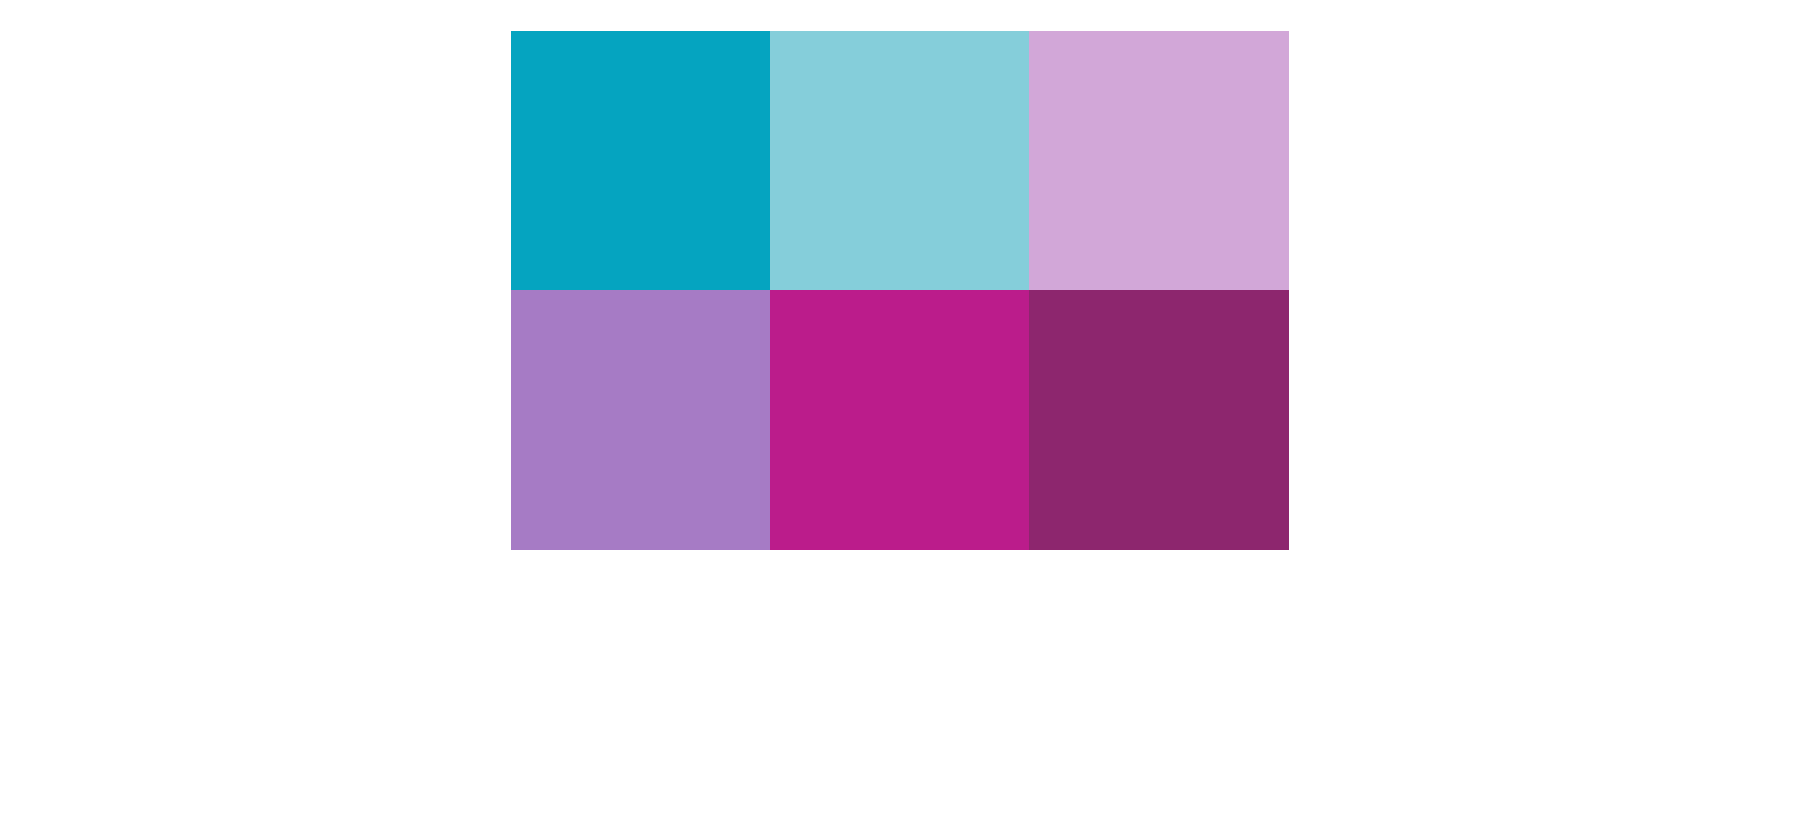

In [2]:
options(repr.plot.width=15, repr.plot.height=7)

# Custom Color Palette
my_colors <- c("#05A4C0", "#85CEDA", "#D2A7D8", "#A67BC5", "#BB1C8B", "#8D266E")
show_col(my_colors, labels = F, borders = NA)


# Custom Theme Variable
my_theme <- theme(plot.background = element_rect(fill = "grey98", color = "grey20"),
                  panel.background = element_rect(fill = "grey98"),
                  panel.grid.major = element_line(colour = "grey87"),
                  text = element_text(color = "grey20"),
                  plot.title = element_text(size = 22),
                  plot.subtitle = element_text(size = 17),
                  axis.title = element_text(size = 15),
                  axis.text = element_text(size = 15),
                  legend.box.background = element_rect(color = "grey20", fill = "grey98", size = 0.1),
                  legend.box.margin = margin(t = 3, r = 3, b = 3, l = 3),
                  legend.title = element_blank(),
                  legend.text = element_text(size = 15),
                  strip.text = element_text(size=17))

### Data📂

First let's inspect the data to see what we're working with. I'm gonna keep it simple, as we'll make it more complicated soon 😁

In [3]:
# Import data information
data <- read_csv("../input/coronavirus-2019ncov/covid-19-all.csv", 
                 col_types = cols(`Country/Region` = col_character(),
                                  `Province/State` = col_character(),
                                  Latitude = col_double(),
                                  Longitude = col_double(),
                                  Confirmed = col_double(),
                                  Recovered = col_double(),
                                  Deaths = col_double(),
                                  Date = col_date(format = "")))
data <- data %>% rename(c("Country" = "Country/Region", "State" = "Province/State"))

tweets <- read_csv("../input/covid19-tweets/covid19_tweets.csv",
                   col_types = cols(user_name = col_character(),
                                    user_location = col_character(),
                                    user_description = col_character(),
                                    user_created = col_datetime(format = ""),
                                    user_followers = col_double(),
                                    user_friends = col_double(),
                                    user_favourites = col_double(),
                                    user_verified = col_logical(),
                                    date = col_datetime(format = ""),
                                    text = col_character(),
                                    hashtags = col_character(),
                                    source = col_character(),
                                    is_retweet = col_logical()))

# Inspect data
data %>% head(5)

# Inspect tweet data
tweets %>% head(2)

Country,State,Latitude,Longitude,Confirmed,Recovered,Deaths,Date
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
China,Anhui,31.8257,117.2264,1,NA,NA,2020-01-22
China,Beijing,40.1824,116.4142,14,NA,NA,2020-01-22
China,Chongqing,30.0572,107.8740,6,NA,NA,2020-01-22
China,Fujian,26.0789,117.9874,1,NA,NA,2020-01-22
China,Gansu,35.7518,104.2861,NA,NA,NA,2020-01-22


user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
<chr>,<chr>,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<lgl>,<dttm>,<chr>,<chr>,<chr>,<lgl>
ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,FALSE,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NA,Twitter for iPhone,FALSE
Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,TRUE,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NA,Twitter for Android,FALSE


In [4]:
# Import some additional data
worldcities <- read_csv("../input/world-cities-database/worldcitiespop.csv",
                        col_types = cols(Country = col_character(),
                                         City = col_character(),
                                         AccentCity = col_character(),
                                         Region = col_character(),
                                         Population = col_double(),
                                         Latitude = col_double(),
                                         Longitude = col_double()))

### Missing Data ❓


### #1. Data dataframe - Overall Information
> `State` has the most missing values, a little above 5% from the overall dataset. There are also some observations that *are missing* important variables like `confirmed`, `recovered` and `deaths`. These observations should be erased from the data. Good news is that the `Country` variable is intact and has no missing values.

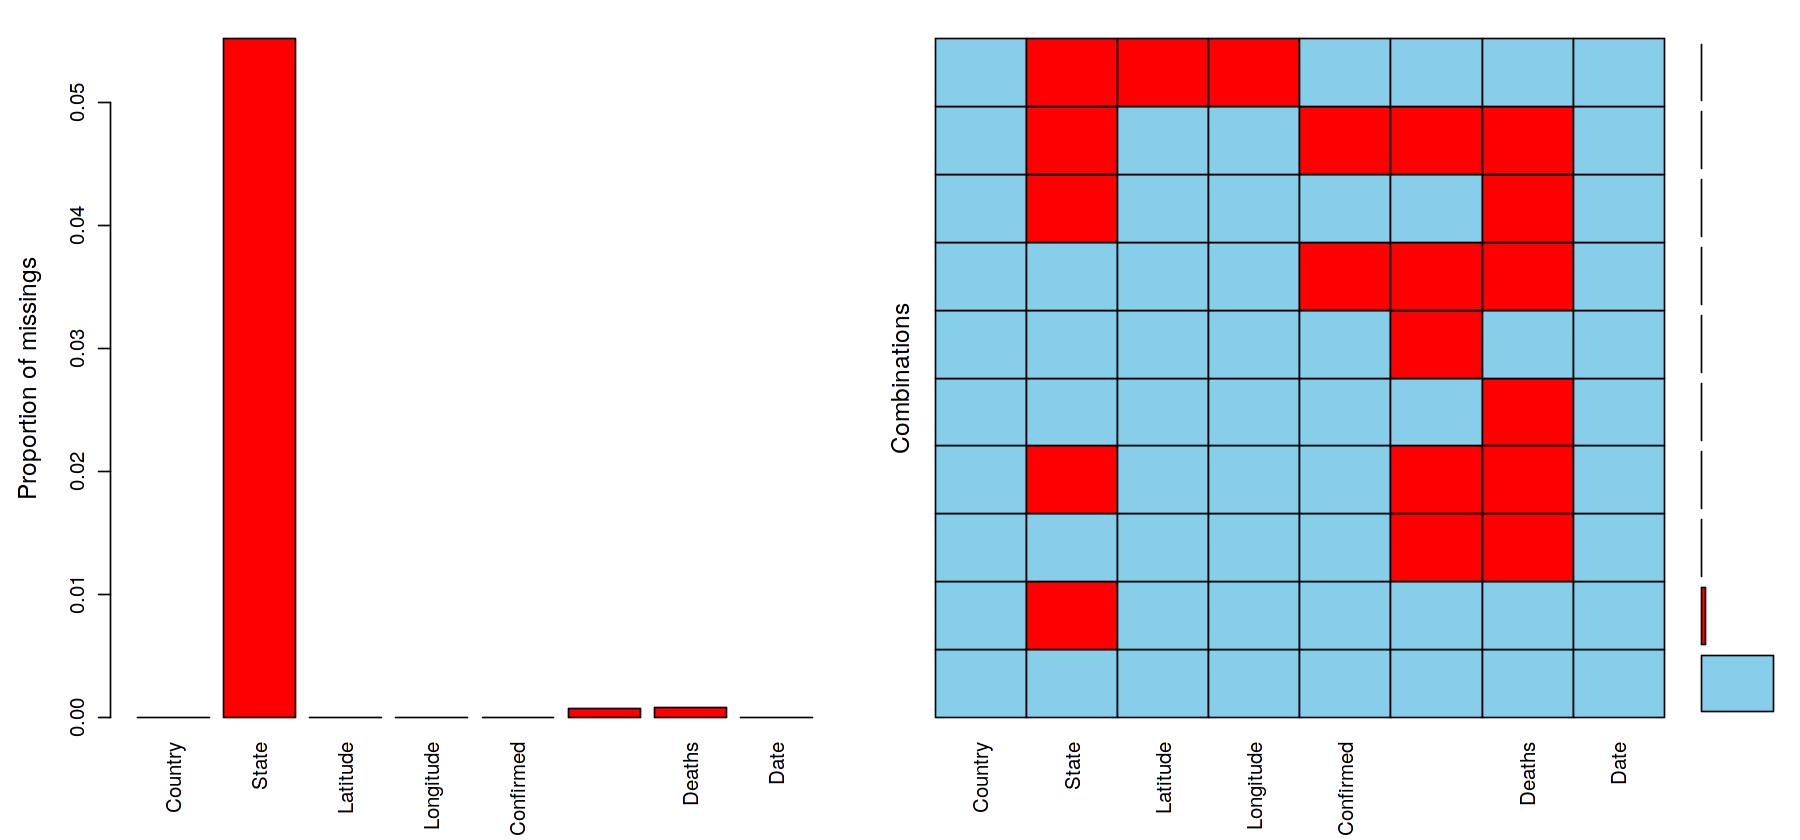

In [5]:
aggr(data)

In [6]:
# Delete values that have the 3 columns missing from the data
data <- na.omit(data, cols=c("Confirmed"))

### #2. Tweets dataframe

> There is missing data only for `user_location`, `user_description`, `hashtags` and `source`. Out of all these columns, `user_location` is one of the most important features, as it gives information about where the tweet was placed, so it can provide some insight into how the sentiment differs from one country to another.

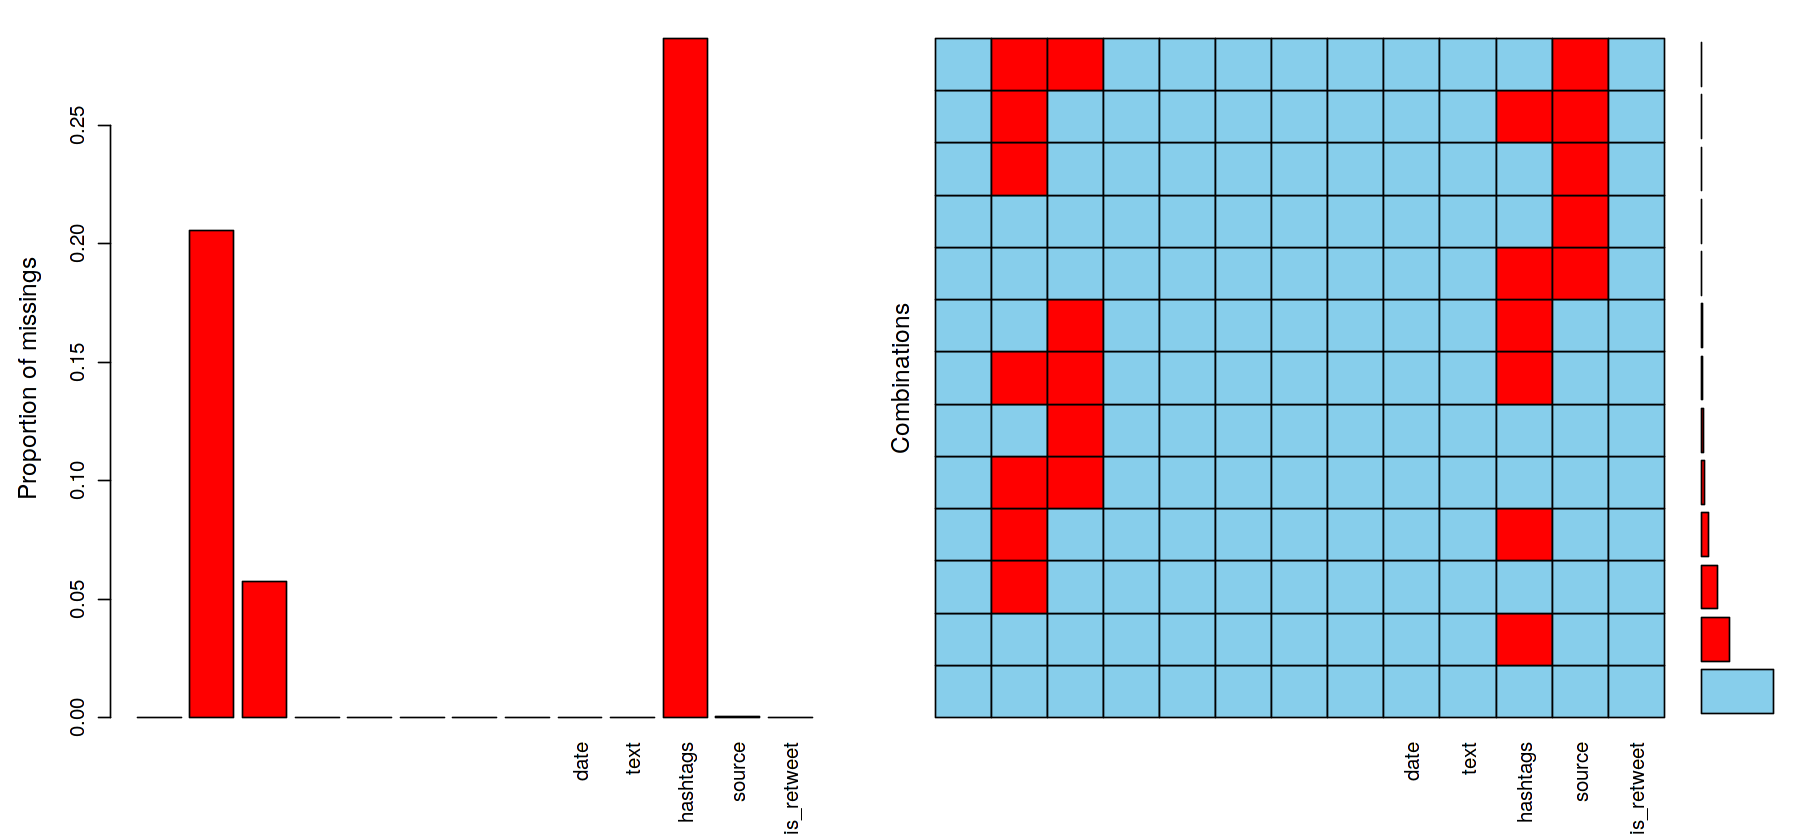

In [7]:
aggr(tweets)

# 3. What's the situation worldwide? 🌍🌎🌏

## Reported Cases in Time 📅
> **📌Note**: Cases are stable in the first quarter of the year. However, starting April they begin to rise first linearly, then almost exponentialy starting July.

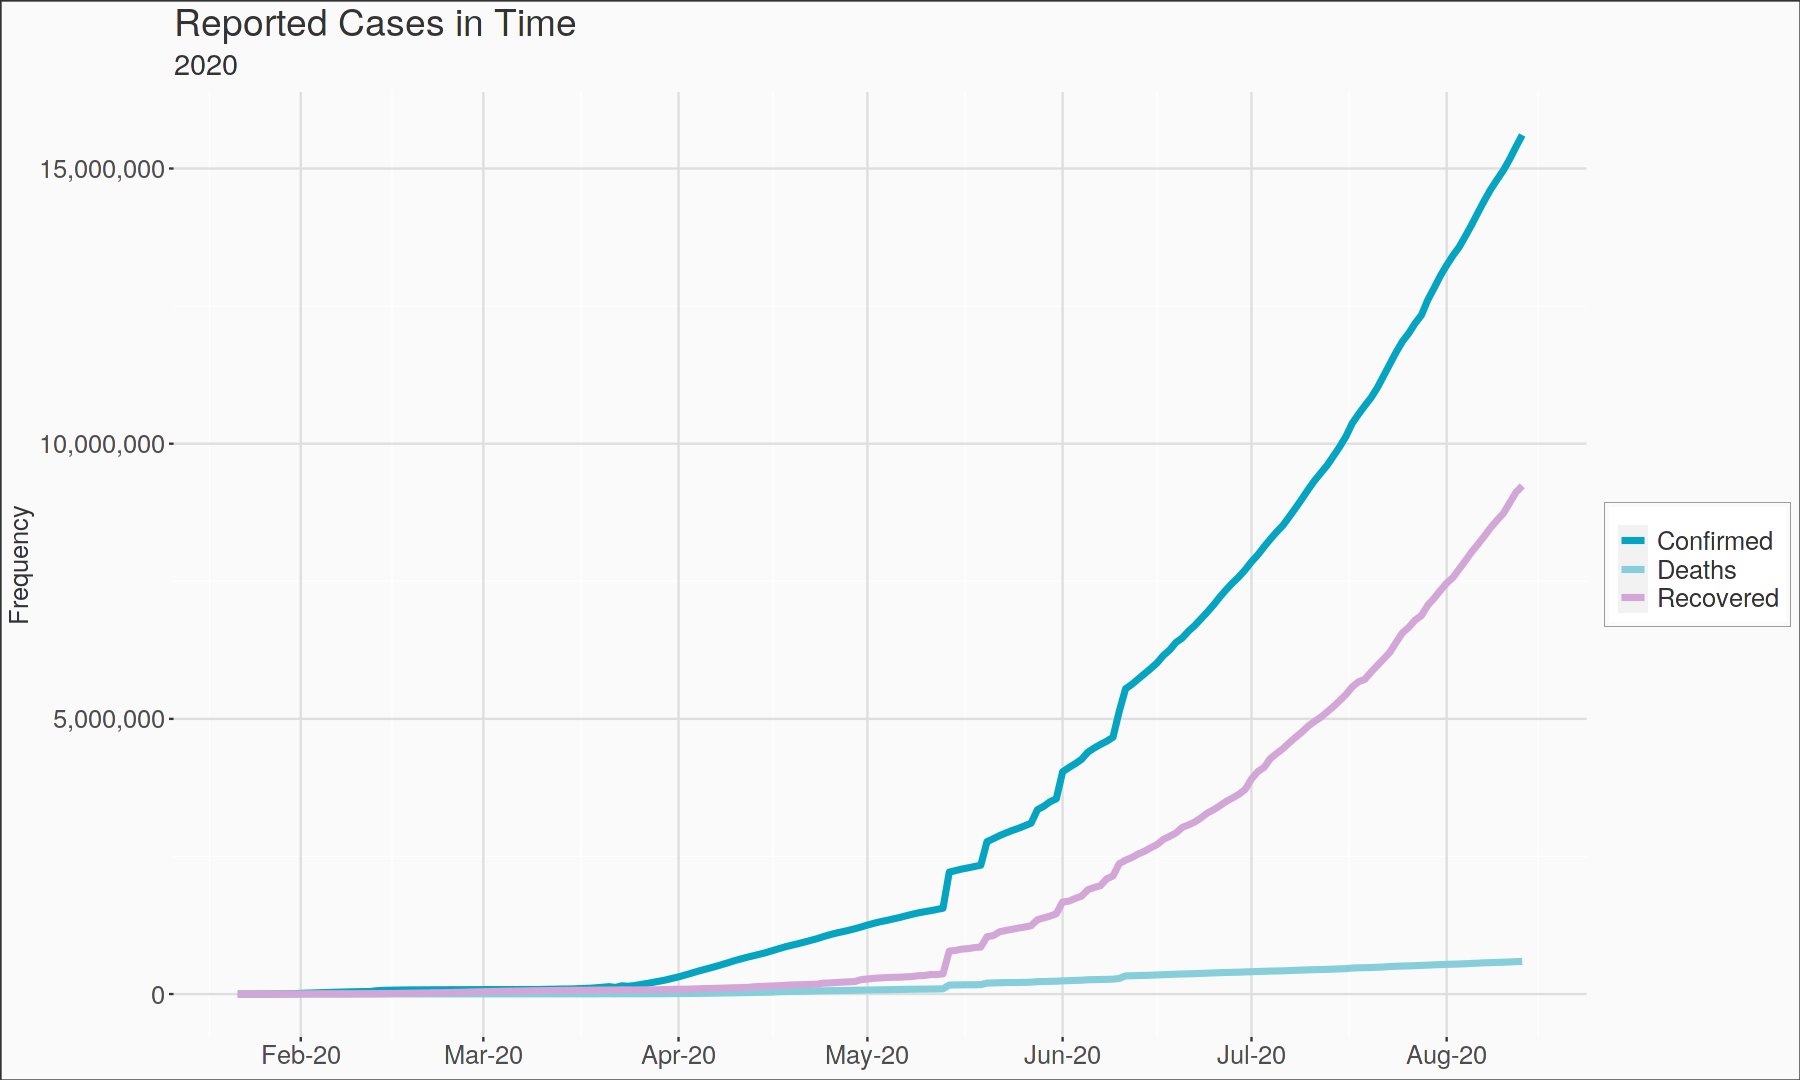

In [8]:
options(repr.plot.width=15, repr.plot.height=9)

data %>%
    select(Date, Confirmed, Recovered, Deaths) %>%
    gather(key = group_var, value = "Cases", -Date, na.rm = TRUE) %>%
    group_by(Date, group_var) %>%
    summarise(n = sum(Cases, na.rm = F), .groups = "drop_last") %>%
    mutate(label = if_else(Date == max(Date), as.character(group_var), NA_character_)) %>% 

    ggplot(aes(x=Date, y = n, color=group_var)) + 
    geom_line(size = 1.5) +
#     geom_label_repel(aes(label = label), nudge_x = 2, hjust=0, na.rm = TRUE, label.size = 0.1, size=3, segment.size = 0.1)
    scale_color_manual(values = my_colors) +
    scale_linetype_manual(values=c("solid", "twodash", "dotted")) +
    coord_cartesian(clip = 'off') +
    scale_y_continuous(labels = scales::comma) +
    scale_x_date(date_breaks = "months" , date_labels = "%b-%y") +
    my_theme + theme(axis.title.x = element_blank()) +
    labs(title = "Reported Cases in Time", subtitle = "2020", y = "Frequency")

## Top Countries per Case Type

> **📌Note**: US has the lead in all cases. *China* is on 18th place in this ranking. Also, it's interesting to see that top 5 countries are from ~different continents; US from North America, Brazil from South America, India from Asia, Russia from Europe and Asia and Spain from Europe.

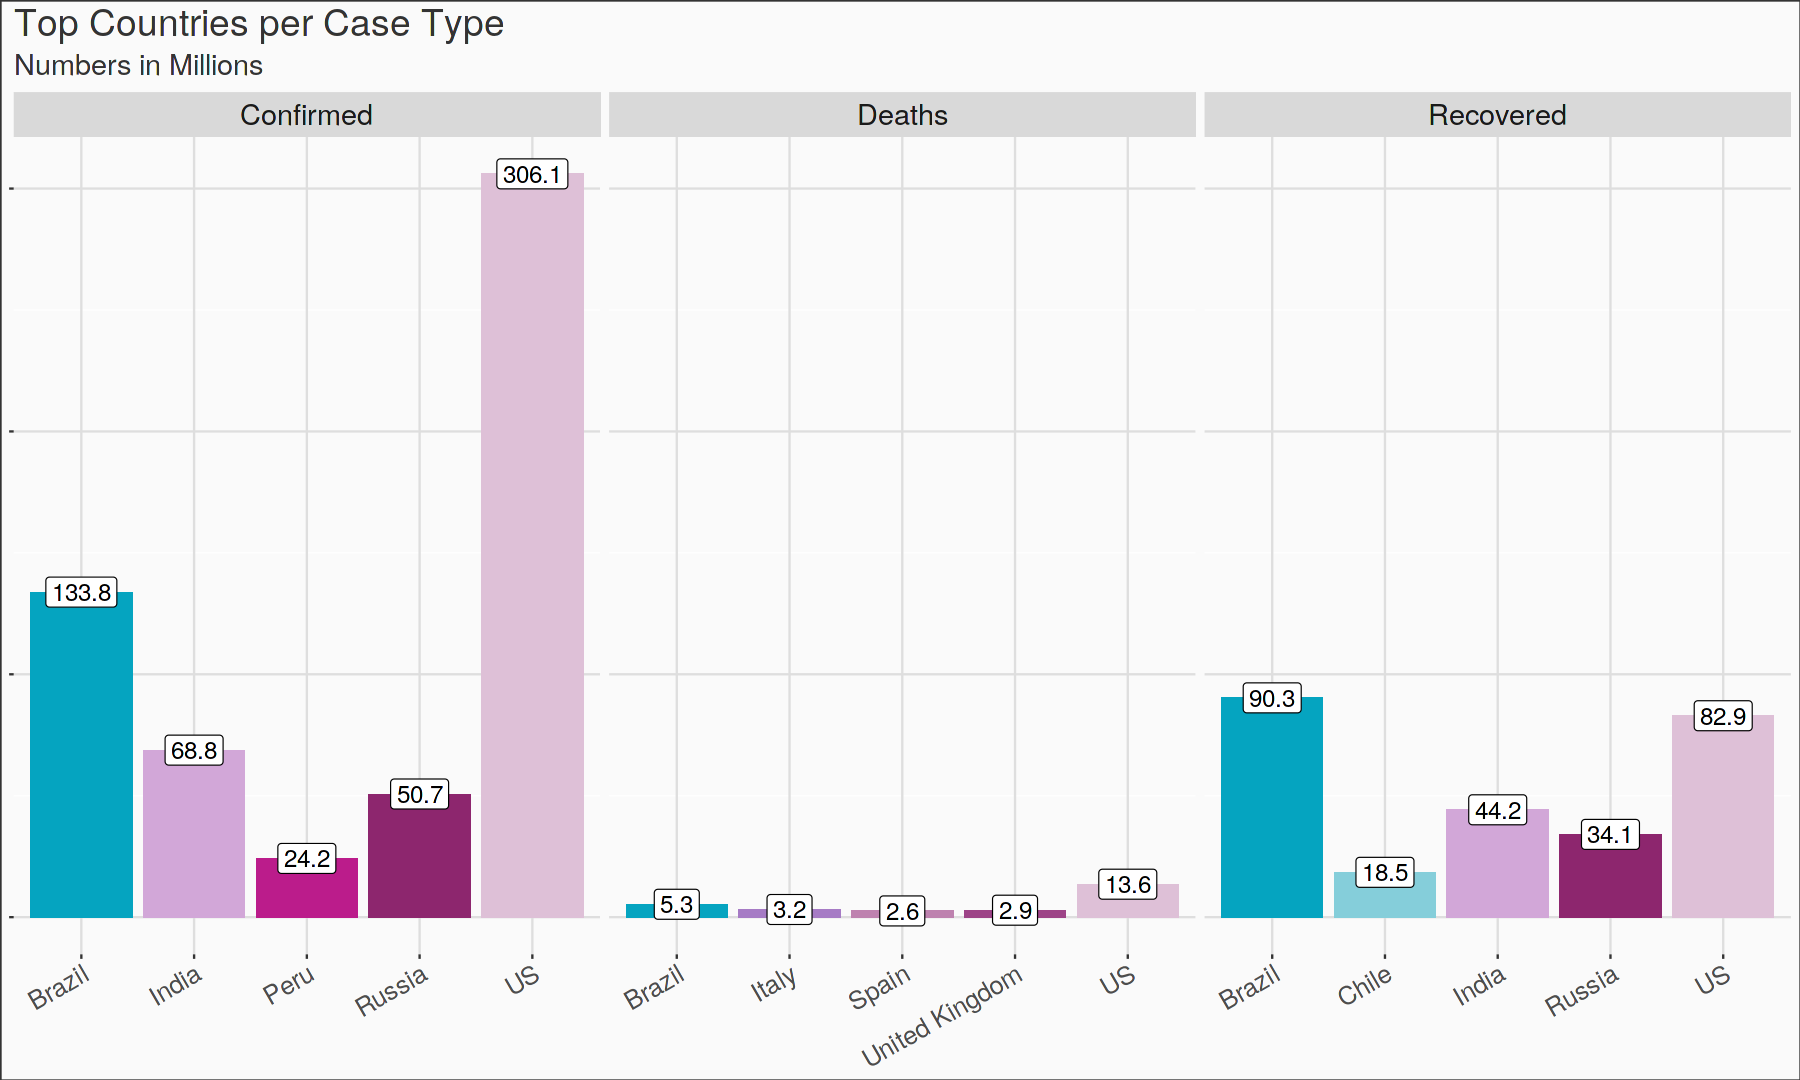

In [9]:
options(repr.plot.width=15, repr.plot.height=9)

data %>%
    select(Country, Confirmed, Recovered, Deaths) %>%
    gather(key = group_var, value = "Cases", -Country, na.rm = TRUE) %>%
    group_by(Country, group_var) %>%
    summarise(n = sum(Cases, na.rm = F), .groups = "drop_last") %>%
    arrange(desc(n)) %>% 
    group_by(group_var) %>% 
    slice(1:5) %>%

    ggplot(aes(x = Country, y = n, fill=Country)) +
    geom_bar(stat = "identity") +
    facet_grid(~ group_var, scales = "free") +
    scale_fill_manual(values = c(my_colors, "#BE82AF", "#9D4387", "#DEC0D7"), guide="none") +
    geom_label(aes(label=round(n/1000000, 1)), size=5, fill="white") +
    labs(title = "Top Countries per Case Type", subtitle = "Numbers in Millions") +
    my_theme + theme(axis.text.y = element_blank(),
                     axis.text.x = element_text(angle = 30, vjust = 1, hjust = 1),
                     axis.title = element_blank())

## Top States per Case Type

> **📌Note**: in *Recovered* category, "Recovered" state is from US. I will figure the state later in the analysis. There is also an "Unknown" state.

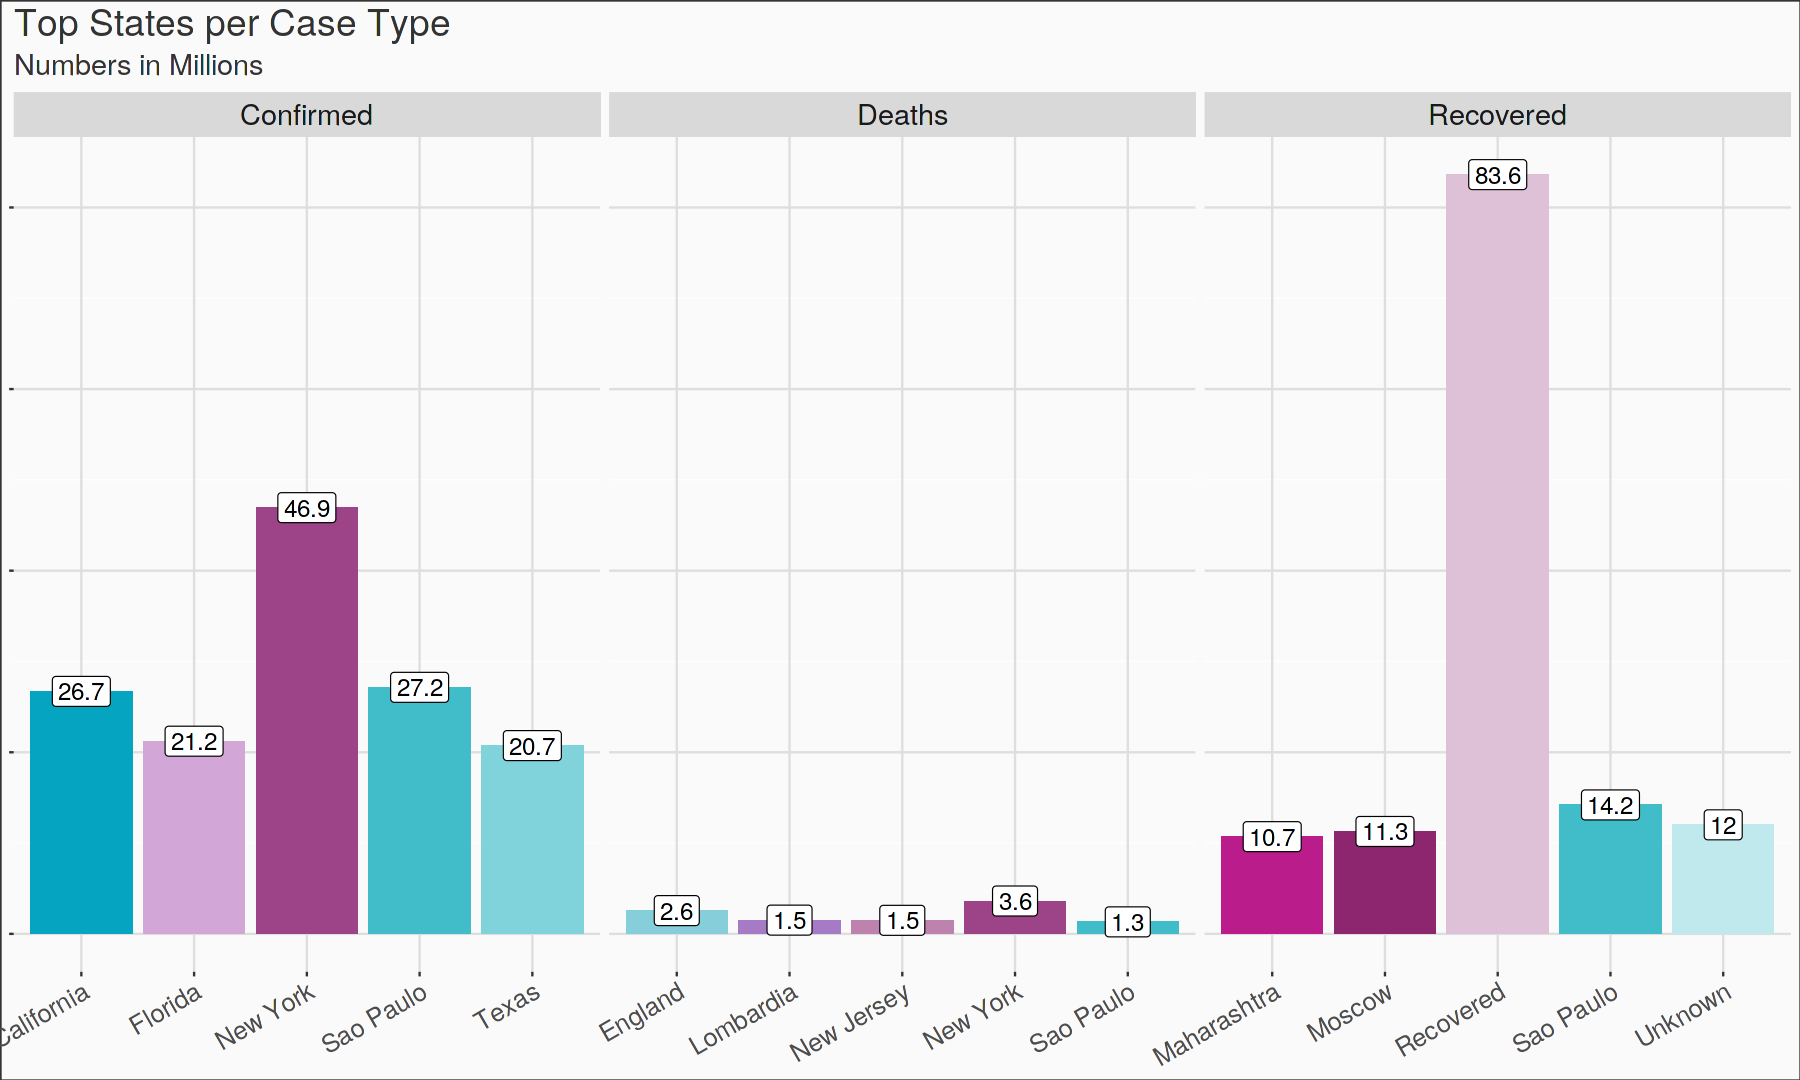

In [10]:
options(repr.plot.width=15, repr.plot.height=9)

data %>%
    filter(State != c("NA", "Unknown")) %>%
    select(State, Confirmed, Recovered, Deaths) %>%
    gather(key = group_var, value = "Cases", -State, na.rm = TRUE) %>%
    group_by(State, group_var) %>%
    summarise(n = sum(Cases, na.rm = F), .groups = "drop_last") %>%
    arrange(desc(n)) %>%
    group_by(group_var) %>% 
    slice(1:5) %>%

    ggplot(aes(x = State, y = n, fill=State)) +
    geom_bar(stat = "identity") +
    facet_grid(~ group_var, scales = "free") +
    scale_fill_manual(values = c(my_colors, "#BE82AF", "#9D4387", "#DEC0D7",
                                 "#40BDC8", "#80D3DB", "#BFE9ED"), guide="none") +
    geom_label(aes(label=round(n/1000000, 1)), size=5, fill="white") +
    labs(title = "Top States per Case Type", subtitle = "Numbers in Millions") +
    my_theme + theme(axis.text.y = element_blank(),
                     axis.text.x = element_text(angle = 30, vjust = 1, hjust = 1),
                     axis.title = element_blank())

# 4. Text Preparation 🐥🐣

## 4.1 Text Mining 🔨🔦

### #1. Clean Corpus Function

This predefined function is going to clean the text from:
* the punctuation - `removePunctuation`
* extra white space - `stripWhitespace`
* transforms to lower case - `tolower`
* stopwords (common words that should be ignored) - `stopwords`
* numbers - `removeNumbers`

In [11]:
cleanCorpus <- function(text){
  # punctuation, whitespace, lowercase, numbers
  text.tmp <- tm_map(text, removePunctuation)
  text.tmp <- tm_map(text.tmp, stripWhitespace)
  text.tmp <- tm_map(text.tmp, content_transformer(tolower))
  text.tmp <- tm_map(text.tmp, removeNumbers)
  
  # removes stopwords
  stopwords_remove <- c(stopwords("en"), c("thats","weve","hes","theres","ive","im",
                                                "will","can","cant","dont","youve","us",
                                                "youre","youll","theyre","whats","didnt"))
  text.tmp <- tm_map(text.tmp, removeWords, stopwords_remove)

  return(text.tmp)
}

### #2. Unigrams | Bigrams | Trigrams
These predefined functions will process the text depending on the case:
* *Unigrams* take only 1 word at a time
* *Bigrams* take 2 sequential words at a time
* *Trigrams* (you guessed) take 3 sequential words at a time

**Term Document Matrix**: it's a mathematical matrix that describes the frequency of terms that occur in a collection of documents. More simply put, is a matrix that has on:
1. rows - words that can be found in the analyzed documents
2. columns - the documents in order
3. values - the frequency of each word in each document

In [12]:
# --- UNIGRAM ---
frequentTerms <- function(text){
  
  # create the matrix
  s.cor <- VCorpus(VectorSource(text))
  s.cor.cl <- cleanCorpus(s.cor)
  s.tdm <- TermDocumentMatrix(s.cor.cl)
  s.tdm <- removeSparseTerms(s.tdm, 0.999)
  m <- as.matrix(s.tdm)
  word_freqs <- sort(rowSums(m), decreasing = T)
  
  # change to dataframe
  dm <- data.frame(word=names(word_freqs), freq=word_freqs)
  
  return(dm)
}


# --- BIGRAM ---
# Bigram tokenizer
tokenizer_2 <- function(x){
  NGramTokenizer(x, Weka_control(min=2, max=2))
}

# Bigram function 
frequentBigrams <- function(text){

  s.cor <- VCorpus(VectorSource(text))
  s.cor.cl <- cleanCorpus(s.cor)
  s.tdm <- TermDocumentMatrix(s.cor.cl, control=list(tokenize=tokenizer_2))
  s.tdm <- removeSparseTerms(s.tdm, 0.999)
  m <- as.matrix(s.tdm)
  word_freqs <- sort(rowSums(m), decreasing=T)
  dm <- data.frame(word=names(word_freqs), freq=word_freqs)
  
  return(dm)
}


# --- TRIGRAM ---
# Trigram tokenizer
tokenizer_3 <- function(x){
  NGramTokenizer(x, Weka_control(min=3, max=3))
}

# Trigram function 
frequentTrigrams <- function(text){

  s.cor <- VCorpus(VectorSource(text))
  s.cor.cl <- cleanCorpus(s.cor)
  s.tdm <- TermDocumentMatrix(s.cor.cl, control=list(tokenize=tokenizer_3))
  s.tdm <- removeSparseTerms(s.tdm, 0.999)
  m <- as.matrix(s.tdm)
  word_freqs <- sort(rowSums(m), decreasing=T)
  dm <- data.frame(word=names(word_freqs), freq=word_freqs)
  
  return(dm)
}

## 4.2 Import Lexicons 📔

A lexicon is a dictionary of words that computes the sentiment of a words by analyzing the "semantic orientation" of that word in a text. These codings are made by people, through crowdsorcing, etc.

* **Afinn**: gives the words a number between [-5, 5], where -5 means that the words is very negative and 5 means that the words is very positive.
* **Bing**: gives the words an assignment of positive/negative sentiment
* **NRC**: assigns the words one of the 8 primary emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and 2 sentiments (positive and negative)

In [13]:
afinn <- read_csv("../input/bing-nrc-afinn-lexicons/Afinn.csv",
                  col_types = cols(word = col_character(), value = col_double()))
bing <- read_csv("../input/bing-nrc-afinn-lexicons/Bing.csv",
                 col_types = cols(word = col_character(), sentiment = col_character()))
nrc <- read_csv("../input/bing-nrc-afinn-lexicons/NRC.csv",
                col_types = cols(word = col_character(), sentiment = col_character()))

## 4.3 Location Cleaning 📍

User location is VERY messy: 
* 36,800 tweets are missing
* rest are a combination of countries, cities, cities & countries, weird characters or vague mentions like *where I want to be*.
* out of 25,280 that have some sort of location I managed to map xx,xxx with a country of origin.


**Fun facts while cleaning text:**
1. Did you know that US has names of towns/cities that are actually other places in the world? They have places like Vienna, India or London. THAT WAS FUN TO MAP ([you cand find more info about this here](https://en.wikipedia.org/wiki/List_of_U.S._places_named_after_non-U.S._places))

<div class="alert alert-block alert-warning">
Location - work in progress.
</div>

In [14]:
# Extract the location to map it separately
tweets_location <- tweets %>%
                        # convert to lower case
                        mutate(user_location = tolower(user_location)) %>%
                        group_by(user_location) %>%
                        summarise(n = n(), .groups = "drop_last") %>%
                        arrange(desc(n))

# Create a new column and fill it with NA
tweets_location$country <- NA

In [15]:
# Manually map some of the locations - if you have better suggestions, shoot! 
# Cuz I'm desperate for a smarter approach
tweets_location <- tweets_location %>%
                        mutate(country = ifelse(grepl("india", user_location), "India", country),
                               country = ifelse(grepl("delhi", user_location), "India", country),
                               country = ifelse(grepl("mumbai", user_location), "India", country),
                               country = ifelse(grepl("bengaluru", user_location), "India", country),
                               country = ifelse(grepl("bangalore", user_location), "India", country),
                               country = ifelse(grepl("bhubaneswar", user_location), "India", country),
                               country = ifelse(grepl("hyderabad", user_location), "India", country),
                               country = ifelse(grepl("china", user_location), "China", country),
                               country = ifelse(grepl("beijing", user_location), "China", country),
                               country = ifelse(grepl("hong kong", user_location), "Hong Kong", country),
                               country = ifelse(grepl("singapore", user_location), "Singapore", country),
                               country = ifelse(grepl("australia", user_location), "Australia", country),
                               country = ifelse(grepl("melbourne", user_location), "Australia", country),
                               country = ifelse(grepl("sydney", user_location), "Australia", country),
                               country = ifelse(grepl("canada", user_location), "Canada", country),
                               country = ifelse(grepl("africa", user_location), "Africa", country),
                               country = ifelse(grepl("england", user_location), "UK", country),
                               country = ifelse(grepl("united kingdom", user_location), "UK", country),
                               country = ifelse(grepl("london", user_location), "UK", country),
                               country = ifelse(grepl("uk", user_location), "UK", country),
                               country = ifelse(grepl("united states", user_location), "US", country),
                               country = ifelse(grepl("usa", user_location), "US", country),
                               country = ifelse(grepl("us", user_location), "US", country),
                               country = ifelse(grepl("washington", user_location), "US", country),
                               country = ifelse(grepl("new york", user_location), "US", country),
                               country = ifelse(grepl("angeles", user_location), "US", country),
                               country = ifelse(grepl("atlanta", user_location), "US", country),
                               country = ifelse(grepl("california", user_location), "US", country),
                               country = ifelse(grepl("chicago", user_location), "US", country),
                               country = ifelse(grepl("boston", user_location), "US", country),
                               country = ifelse(grepl("philadelphia", user_location), "US", country),
                               country = ifelse(grepl("diego", user_location), "US", country),
                               country = ifelse(grepl("seattle", user_location), "US", country),
                               country = ifelse(grepl("texas", user_location), "US", country),
                               country = ifelse(grepl("nyc", user_location), "US", country),
                               country = ifelse(grepl("vegas", user_location), "US", country),
                               country = ifelse(grepl("francisco", user_location), "US", country),
                               country = ifelse(grepl("florida", user_location), "US", country),
                               country = ifelse(grepl("dallas", user_location), "US", country),
                               country = ifelse(grepl("denver", user_location), "US", country),
                               country = ifelse(grepl("worldwide", user_location), "NoCountry", country),
                               country = ifelse(grepl("global", user_location), "NoCountry", country),
                               country = ifelse(grepl("earth", user_location), "NoCountry", country),
                               country = ifelse(grepl("everywhere", user_location), "NoCountry", country),
                               country = ifelse(grepl("nigeria", user_location), "Nigeria", country),
                               country = ifelse(grepl("kenya", user_location), "Kenya", country),
                               country = ifelse(grepl("switzerland", user_location), "Switzerland", country),
                               country = ifelse(grepl("ireland", user_location), "Ireland", country),
                               country = ifelse(grepl("canada", user_location), "Canada", country),
                               country = ifelse(grepl("toronto", user_location), "Canada", country),
                               country = ifelse(grepl("philippines", user_location), "Philippines", country),
                               country = ifelse(grepl("malaysia", user_location), "Malaysia", country),)

In [16]:
# US Cities
us_cities <- worldcities %>%
                filter(Country == "us") %>%
                mutate(Country = "US") %>%
                select(Country, City, AccentCity)

# Cross locations with cities to extract the country
tweets_location$flag_us <- purrr::map_df(tweets_location, ~ .x %in% us_cities$City)$user_location

In [17]:
# Add the new `country` column
tweets <- tweets %>%
            left_join(tweets_location, by = "user_location") %>%
            select(-c(n, flag_us))

## 4.4 Prepare Data: *unnest_tweets*

> `unnest_tokens()` function breaks the sentences in words; so, from a row with a sentence of 5 words you afterwards get 5 rows, with each word on a different row.

In [18]:
# Breaks the tweet into words on each row
# in order to append the "sentiment" of the tweet
unnest_tweets <- tweets %>% 
    mutate(text = as.character(tweets$text)) %>% 
    unnest_tokens(word, text)

## 4.5 Stopwords List

> These are link words, pronouns, negations, etc. that usually don't have any sentiment meaning and can be removed from the text itself.

In [19]:
# Create a dataframe with stopwords
stopwords_script <- tibble(word = c(stopwords("en"), c("thats","weve","hes","theres","ive","im",
                                                           "will","can","cant","dont","youve","us",
                                                           "youre","youll","theyre","whats","didnt", "just")))

## 4.6 Date/Time Feature Engineering 📆

> These features will be handy later, when tweets will be recorded over a fiew months, so we can notice some patterns over time in activity and behavior.

In [20]:
tweets <- tweets %>%
            mutate(day_of_month = mday(date),
                   month = month(date),
                   season = ifelse(month %in% c(12, 1, 2), "Winter",
                                   ifelse(month %in% c(3, 4, 5), "Spring", 
                                          ifelse(month %in% c(6, 7, 8), "Summer", "Winter"))),
                   )

# 5. Basic EDA on Tweets Data

## 5.1 Ammount of Tweets in Time 📅

> **📌Note**: Data was collected over the last 2 months (July and Sept 2020). Maximum ammount of tweets in a day is 26, while the minimum ammount is 1. The intensity has been slightly decreasing over time.

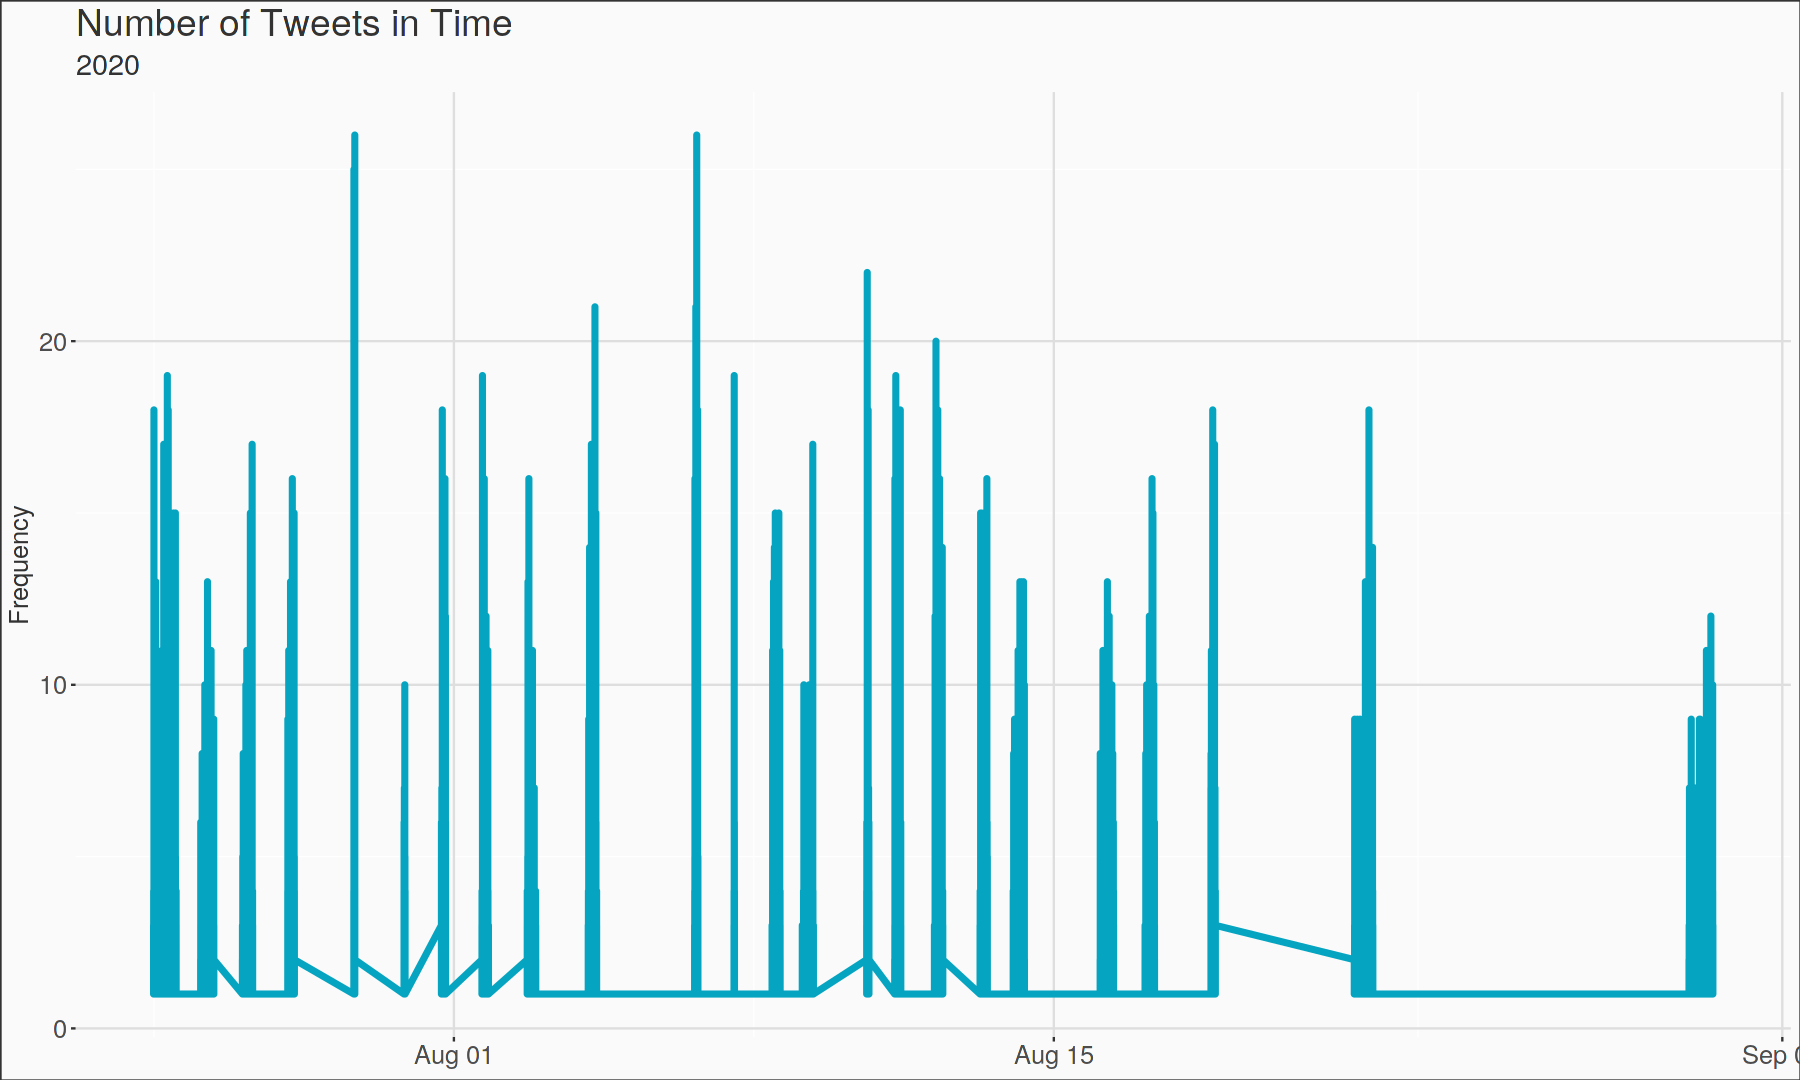

In [21]:
options(repr.plot.width=15, repr.plot.height=9)

tweets %>% 
    select(date) %>% 
    mutate(date = ymd_hms(date)) %>% 
    group_by(date) %>% 
    summarize(n = n(), .groups = "drop_last") %>%

    ggplot(aes(x=date, y = n)) + 
    geom_line(size = 1.5, color = my_colors[1]) +
    coord_cartesian(clip = 'off') +
    my_theme + theme(axis.title.x = element_blank()) +
    labs(title = "Number of Tweets in Time", subtitle = "2020", y = "Frequency")

## 5.2 User Location 📍

<div class="alert alert-block alert-warning">
Location - work in progress.
</div>

> India, US and "All over the world" are the location of most of the tweets (kiip in mind we're looking now only at english tweets). However, as you may know, there are over 7,000 languages out there, and the importance of NLP goes beyond English ([here is a great article about this](https://ruder.io/nlp-beyond-english/))

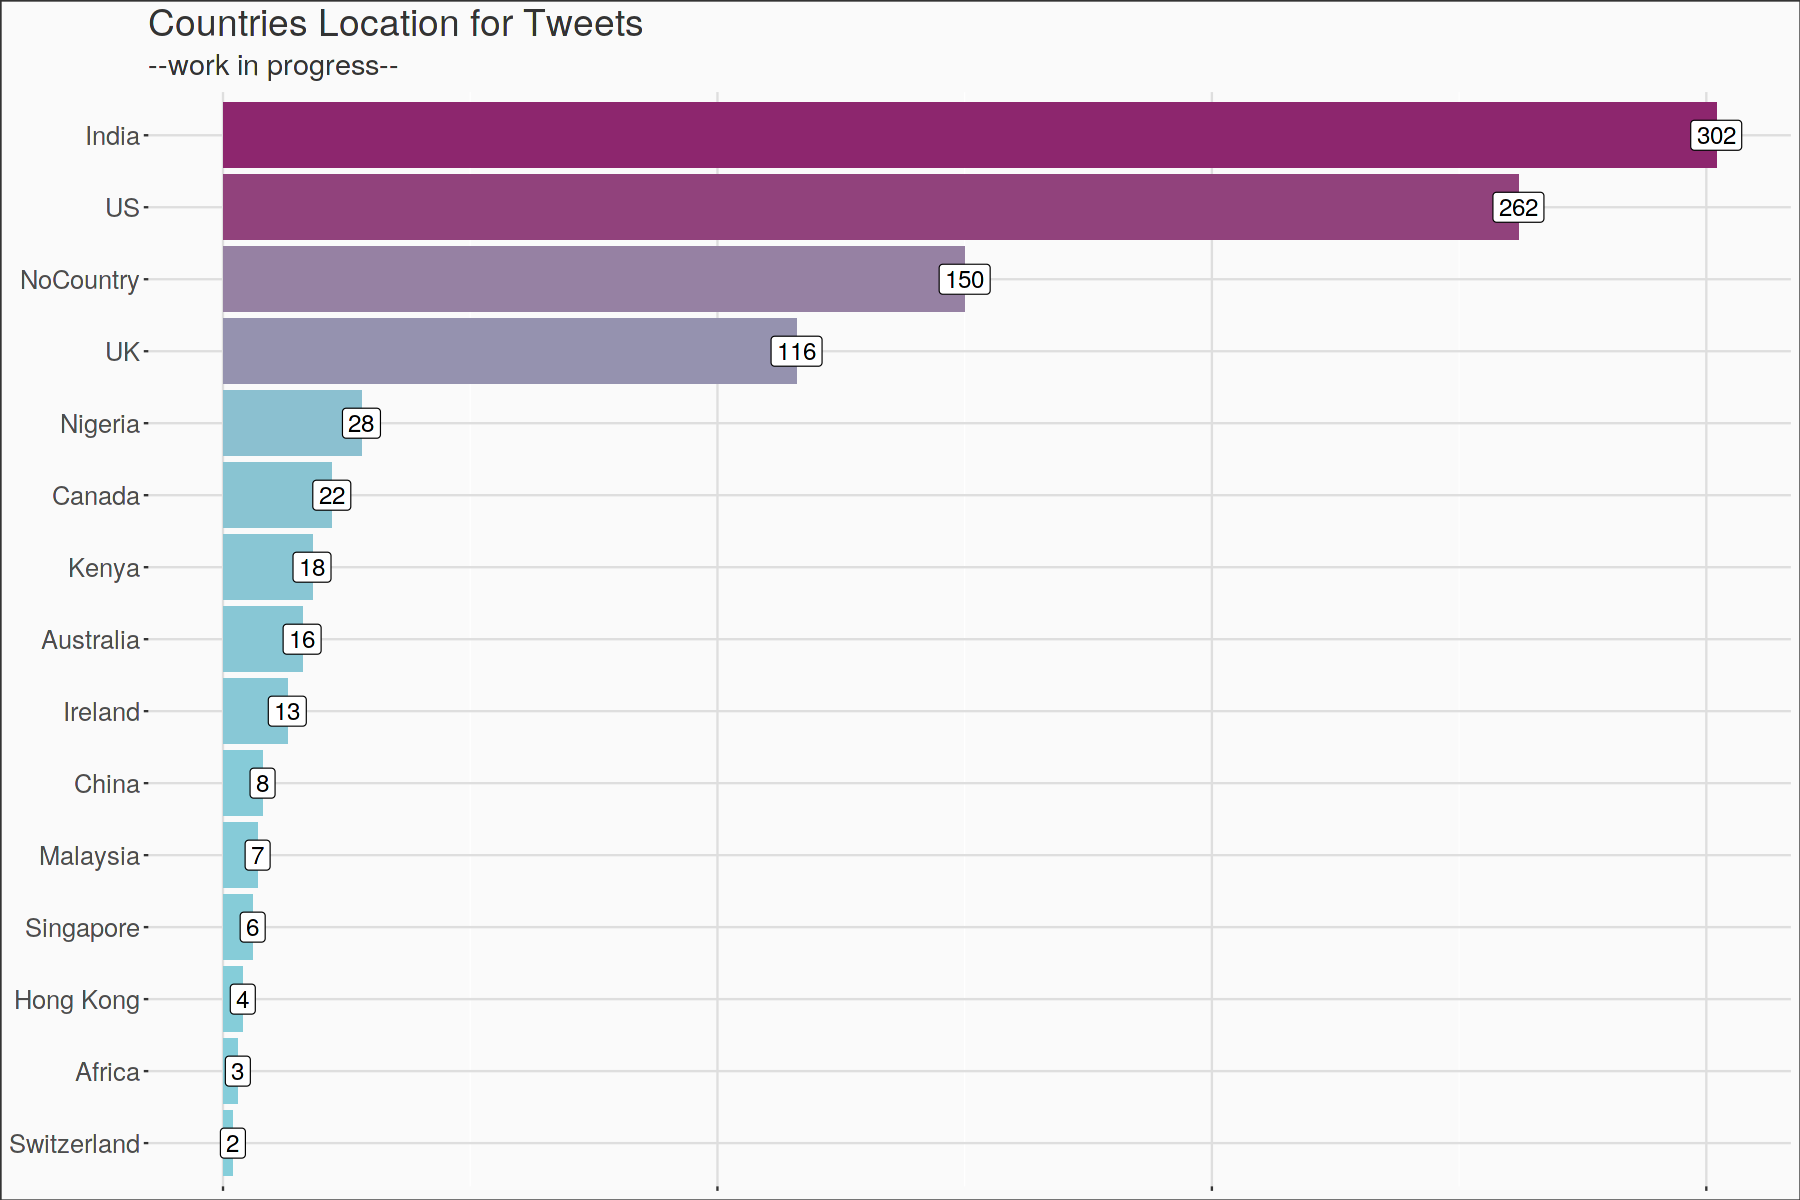

In [22]:
options(repr.plot.width=15, repr.plot.height=10)

tweets %>%
    group_by(country) %>%
    summarise(n = n(), .groups = "drop_last") %>%
    filter(country != "NA") %>%

    ggplot(aes(x = reorder(country, n), y = n, fill=n)) +
    geom_bar(stat = "identity") +
    coord_flip() +
    scale_fill_gradient(low=my_colors[2], high=my_colors[6], guide="none") +
    geom_label(aes(label=n), size=5, fill="white") +
    labs(title = "Countries Location for Tweets", subtitle = "--work in progress--") +
    my_theme + theme(axis.text.x = element_blank(),
                     axis.title = element_blank())

## 5.3 User Profile

> **📌Note**: The overall profiles are small, but there are some tweets from very big accounts, with more than 40 mils followers (CNN, National Geographic and CGTN - China Global Television Network - are some of them).

<img src="https://i.imgur.com/KFKErPb.png" width= 650>

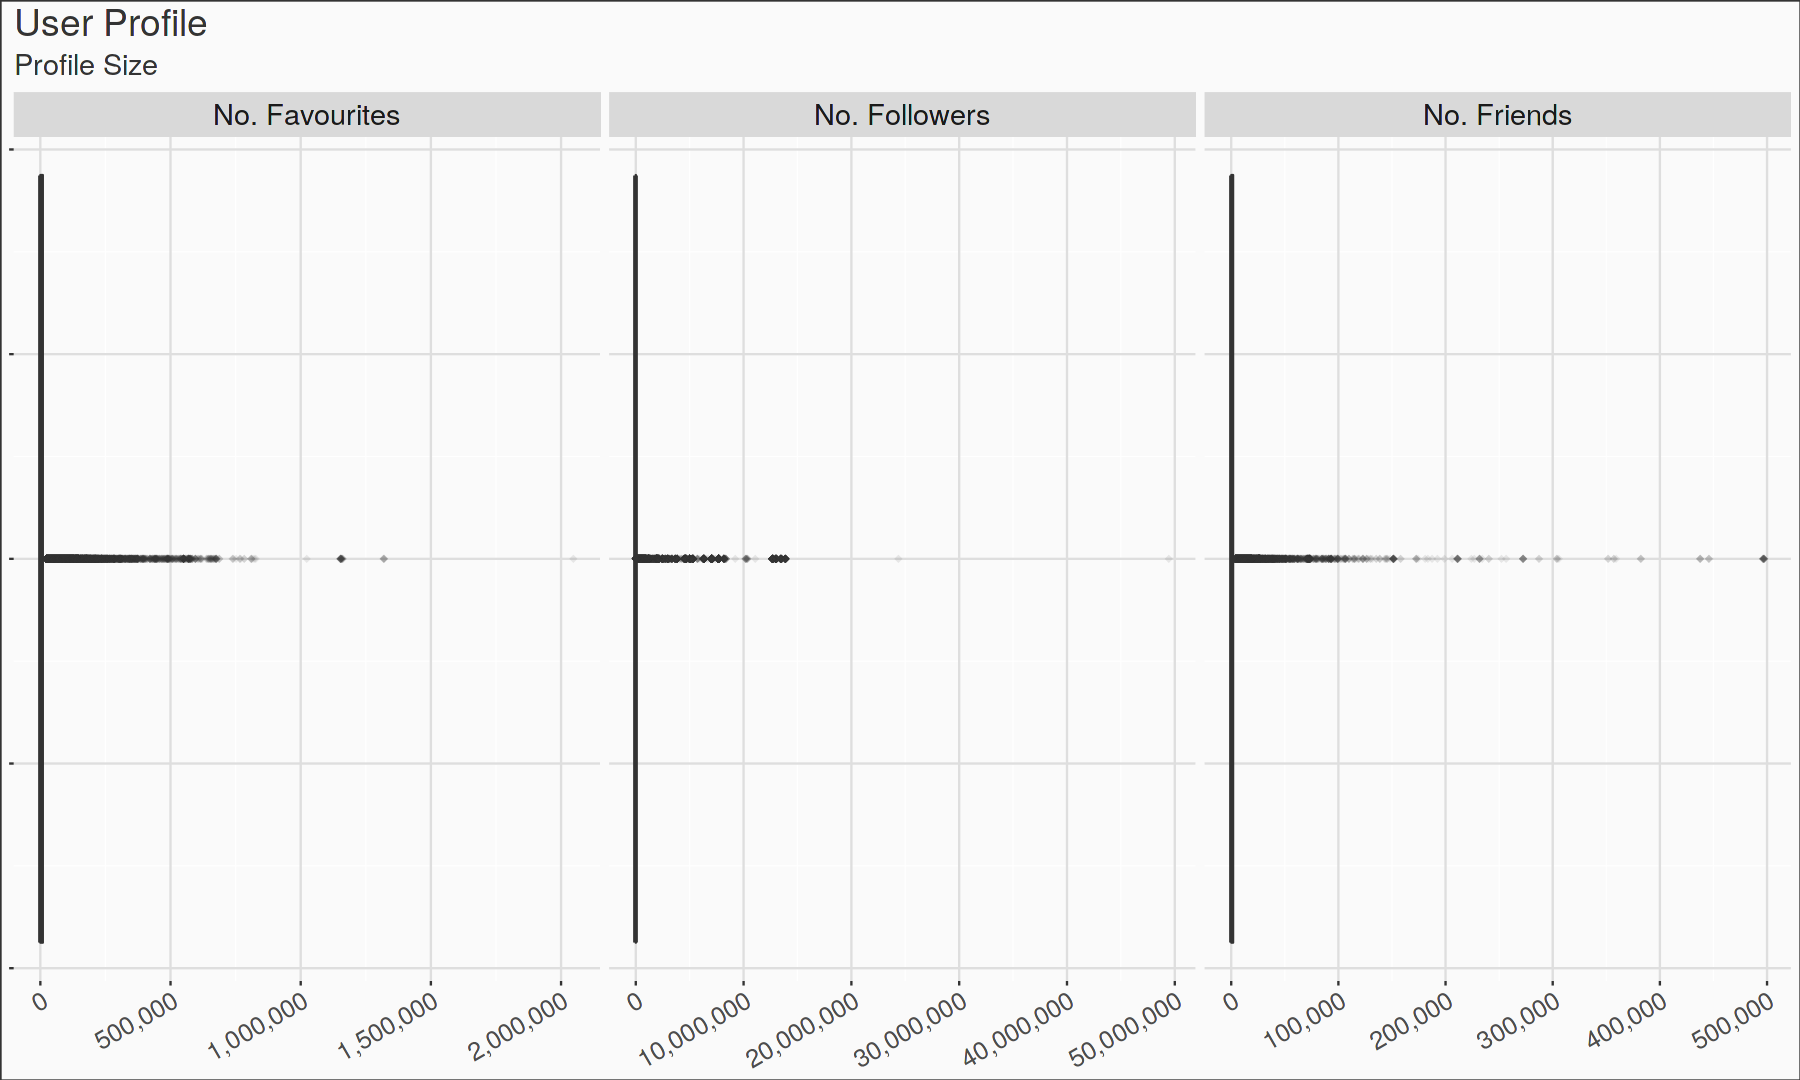

In [23]:
options(repr.plot.width=15, repr.plot.height=9)
labels <- c("user_favourites" = "No. Favourites", "user_followers" = "No. Followers", 
            "user_friends" = "No. Friends")

tweets %>%
    select(user_followers, user_favourites, user_friends) %>%
    gather(key = group_var, value = "Cases", na.rm = TRUE) %>%
    
    ggplot(aes(x = Cases)) +
    geom_boxplot(aes(fill = group_var), outlier.fill = "grey35", outlier.shape = 18, 
                 outlier.alpha = 0.1, outlier.size = 2) +
    facet_grid(~ group_var, scales = "free", labeller = as_labeller(labels)) +
    scale_x_continuous(labels = comma) +
    scale_fill_manual(values = my_colors, guide = "none") +
    labs(title = "User Profile", subtitle = "Profile Size") +
    my_theme + theme(axis.text.y = element_blank(),
                     axis.text.x = element_text(angle = 30, vjust = 1, hjust = 1),
                     axis.title = element_blank())

# 6. Sentiment Analysis

## 6.1 Positive-Negative Wordcloud🙂😒

> **📌Note**: Some of the most Negative words are **death, virus, risk, infections**, while some of the most Positive words are **free, work, great, support, recovery**. 

Why is *trump* there?

trump (noun): (in bridge, whist, and similar card games) a playing card of the suit chosen to rank above the others, which can win a trick where a card of a different suit has been led.

So, this is why the word **trump** is characterized as positive.

> **📌Another Note**: in this lexicon, the word "positive" is of course categorized as - positive. However, we all know that most of the "positive" appearences in the tweets talk about "positive case", or "confirmed positives". This is a downside of using lexicons for sentiment analysis - they analyze the words, but they DON'T take into account the meaning of the word in the sentence.

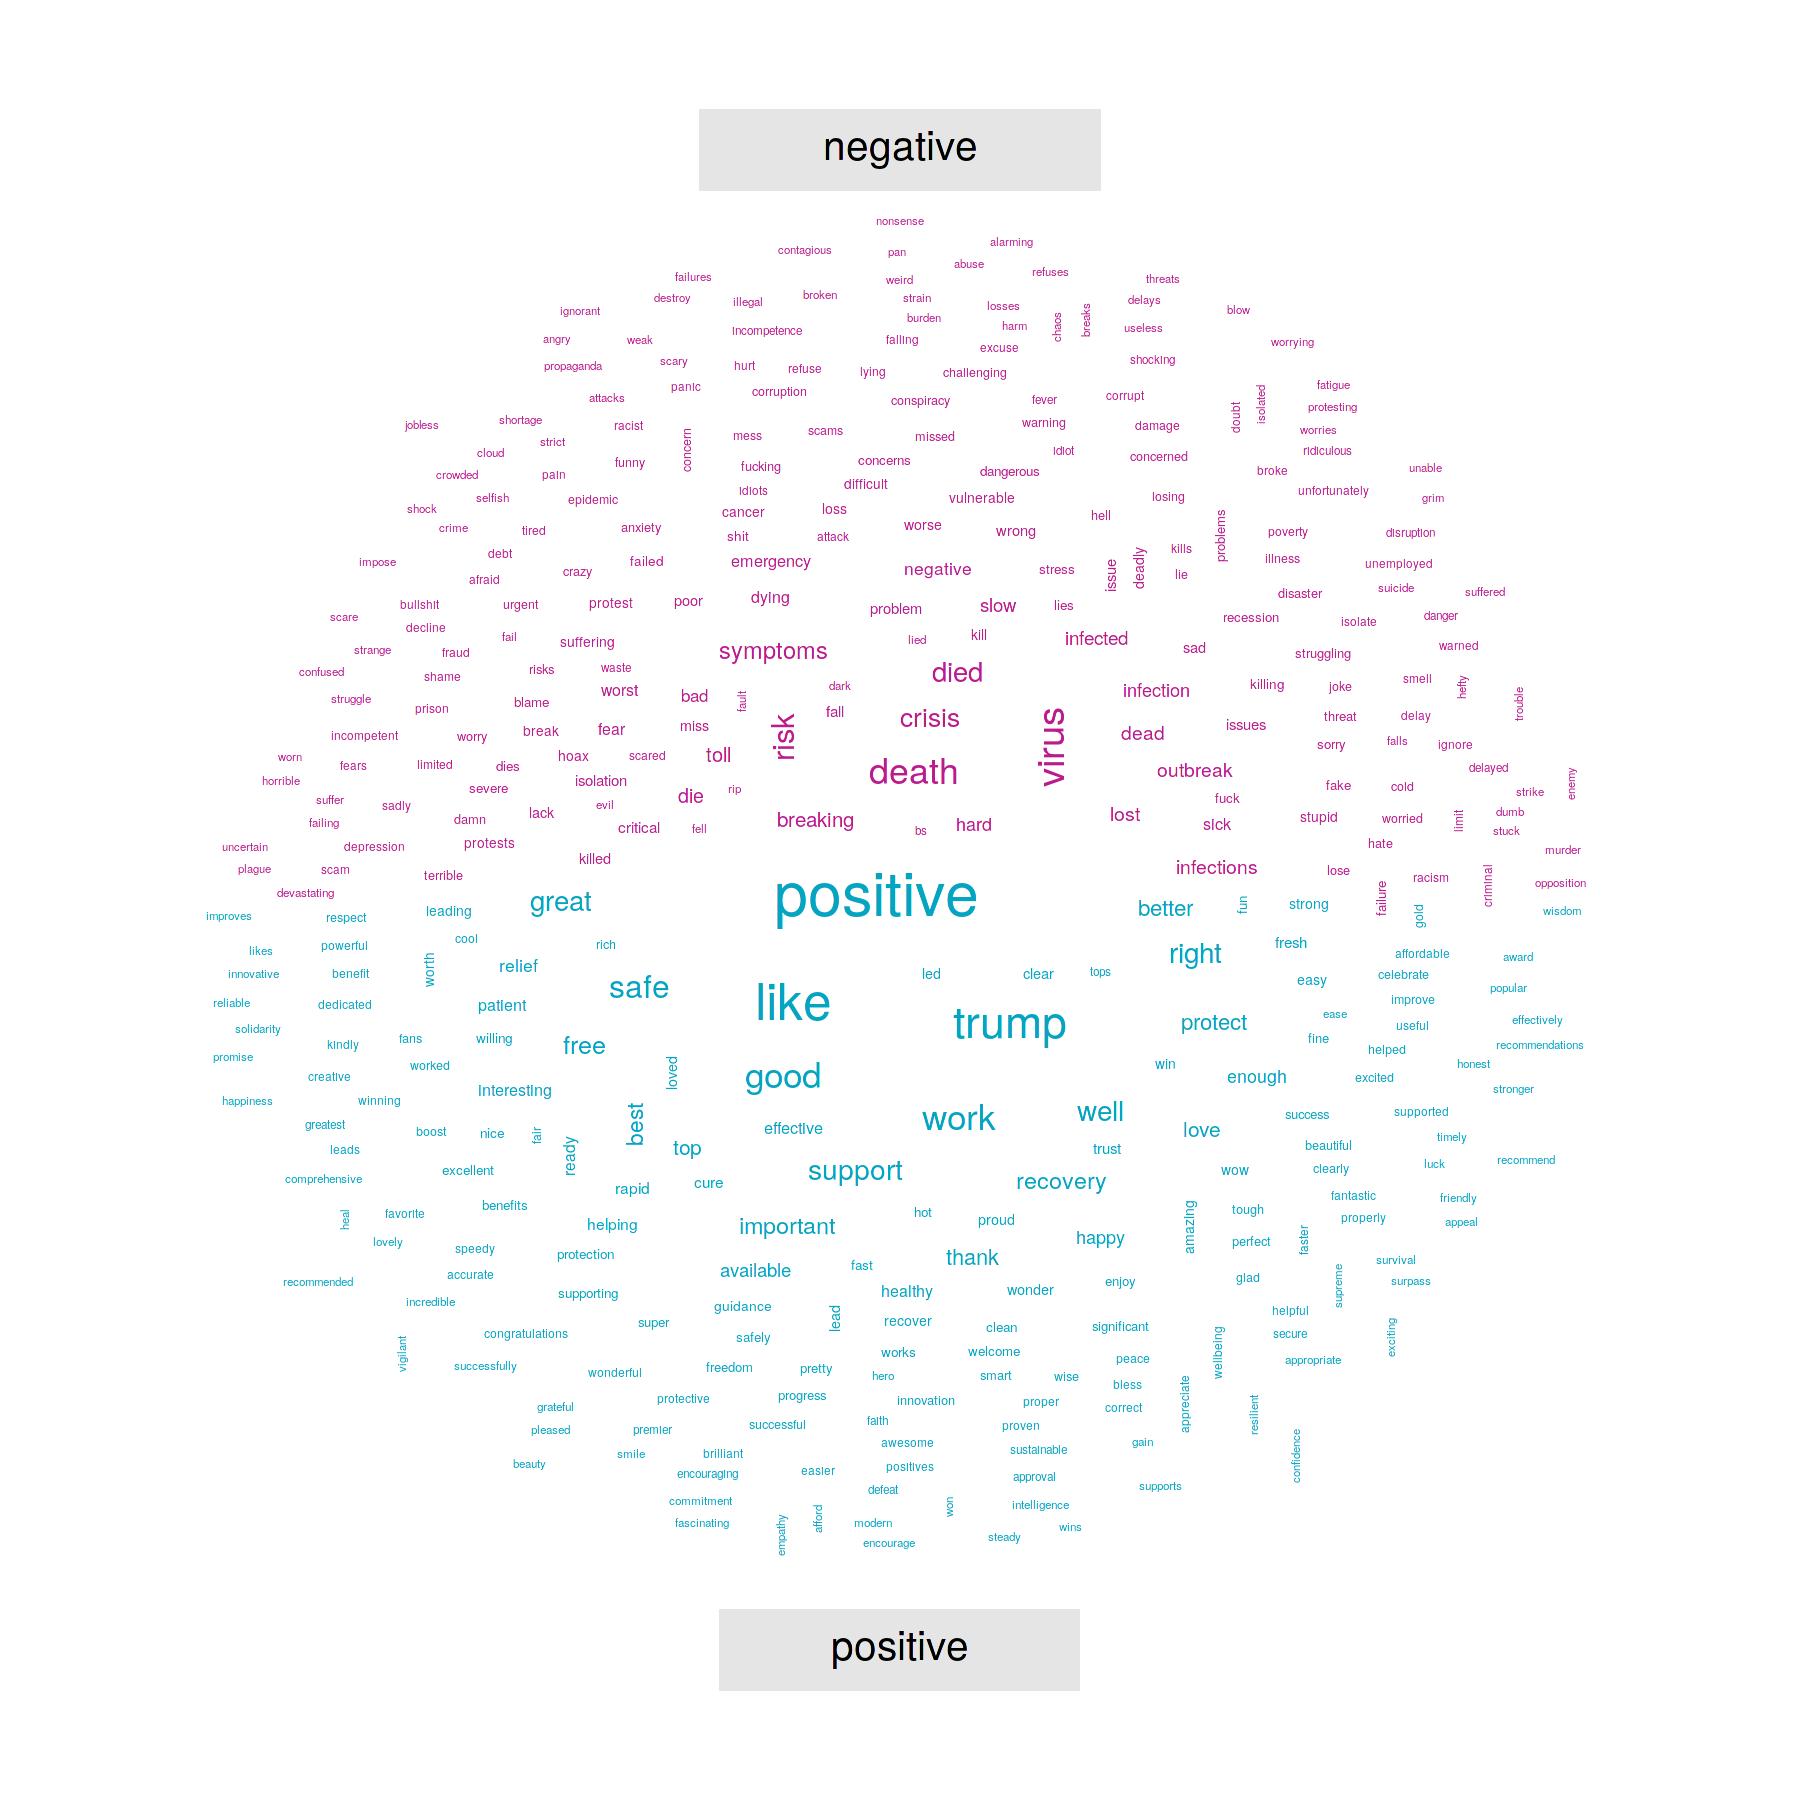

In [24]:
options(repr.plot.width=15, repr.plot.height=15)

unnest_tweets %>% 
    inner_join(bing, by="word") %>%
    count(word, sentiment, sort=T) %>% 
    acast(word ~ sentiment, value.var = "n", fill=0) %>% 
  
    # wordcloud
    comparison.cloud(colors=my_colors[c(5, 1)], max.words = 400, title.size = 2,
                  scale = c(3,.5))

## 6.2 Primary Emotions Analysis
> **📌Note**: Trust, Fear and Anticipation are found the most in the tweets. 

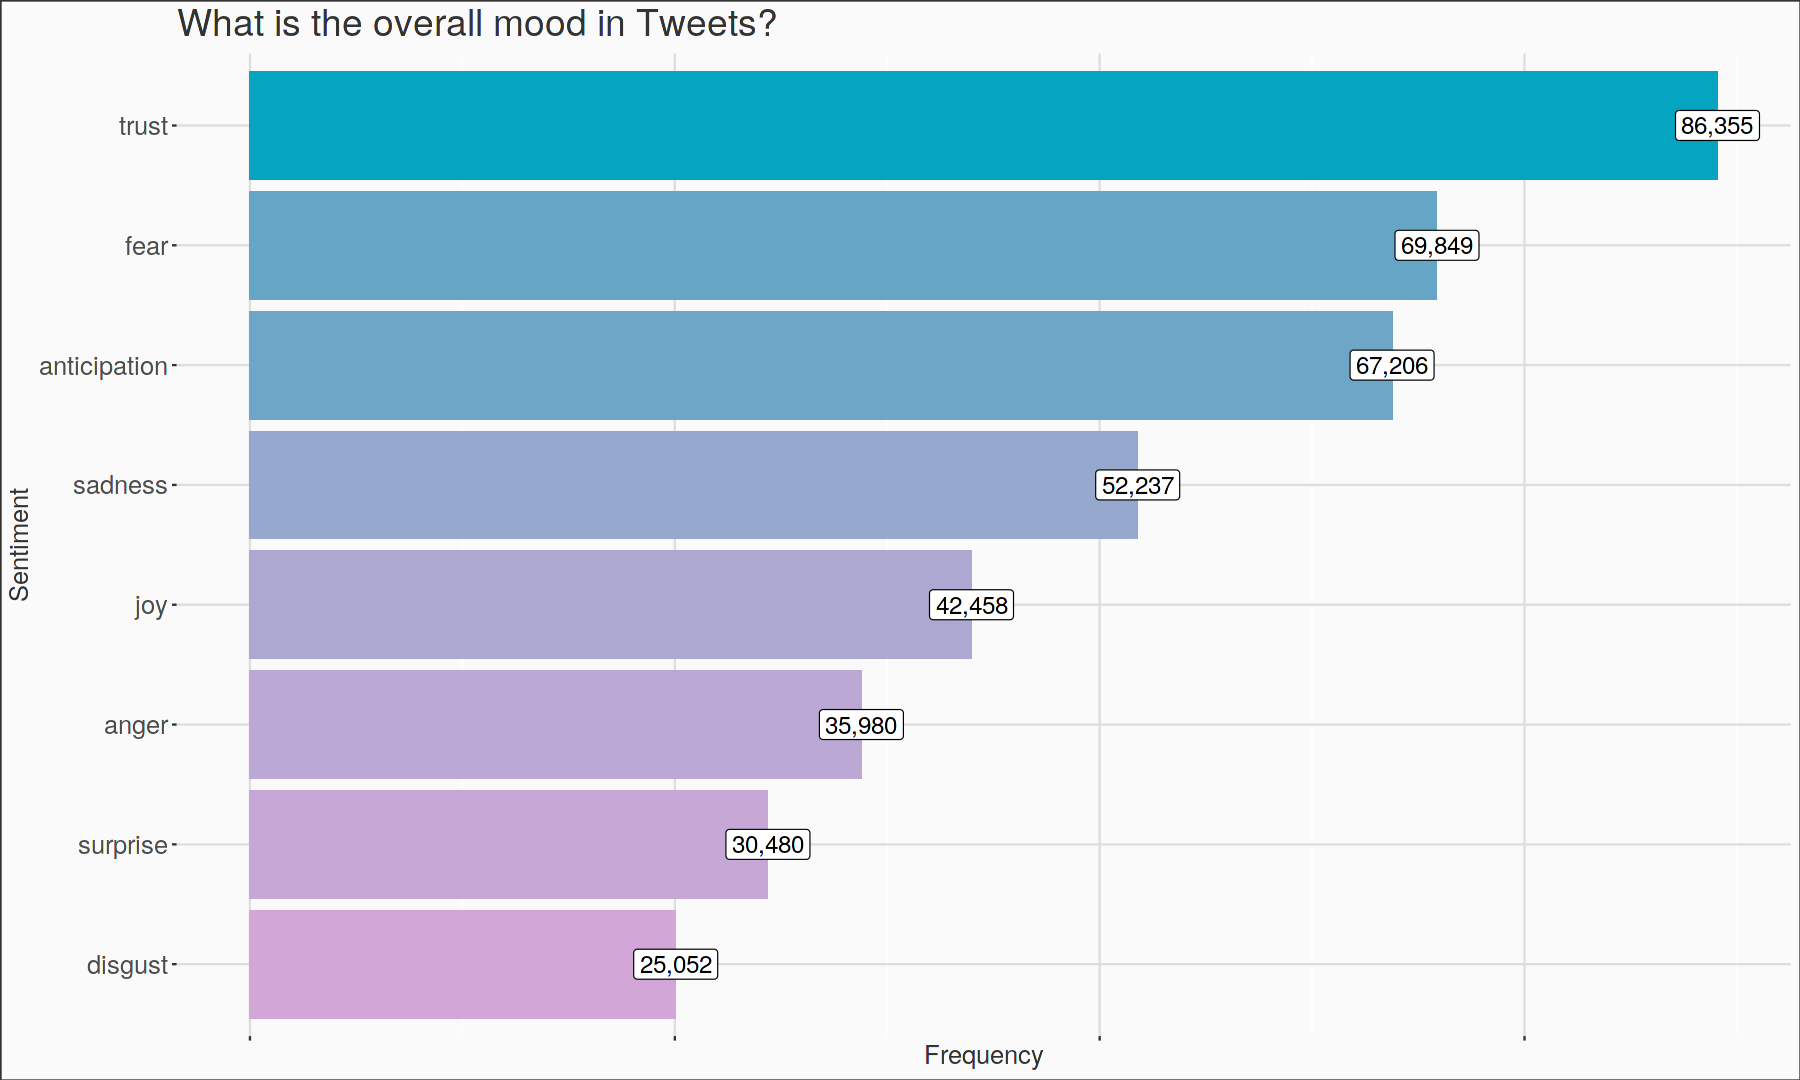

In [25]:
options(repr.plot.width=15, repr.plot.height=9)

# The plot:
unnest_tweets %>% 
    inner_join(nrc, "word") %>%
    filter(!sentiment %in% c("positive", "negative")) %>% 
    count(sentiment, sort=T) %>% 

    ggplot(aes(x=reorder(sentiment, n), y=n)) +
    geom_bar(stat="identity", aes(fill=n), show.legend=F) +
    geom_label(aes(label=format(n, big.mark = ",")), size=5, fill="white") +
    labs(x="Sentiment", y="Frequency", title="What is the overall mood in Tweets?") +
    scale_fill_gradient(low = my_colors[3], high = my_colors[1], guide="none") +
    coord_flip() + 
    my_theme + theme(axis.text.x = element_blank())

## 6.3 Emotions Split by Words 

> **📌Note**: We know that Trust, Fear and Anticipation have the biggest influence overall:
* `Trust:` good, school, safe, hospital
* `Fear:` pandemic, death, government, sick
* `Anticipation:` time, daily, watch

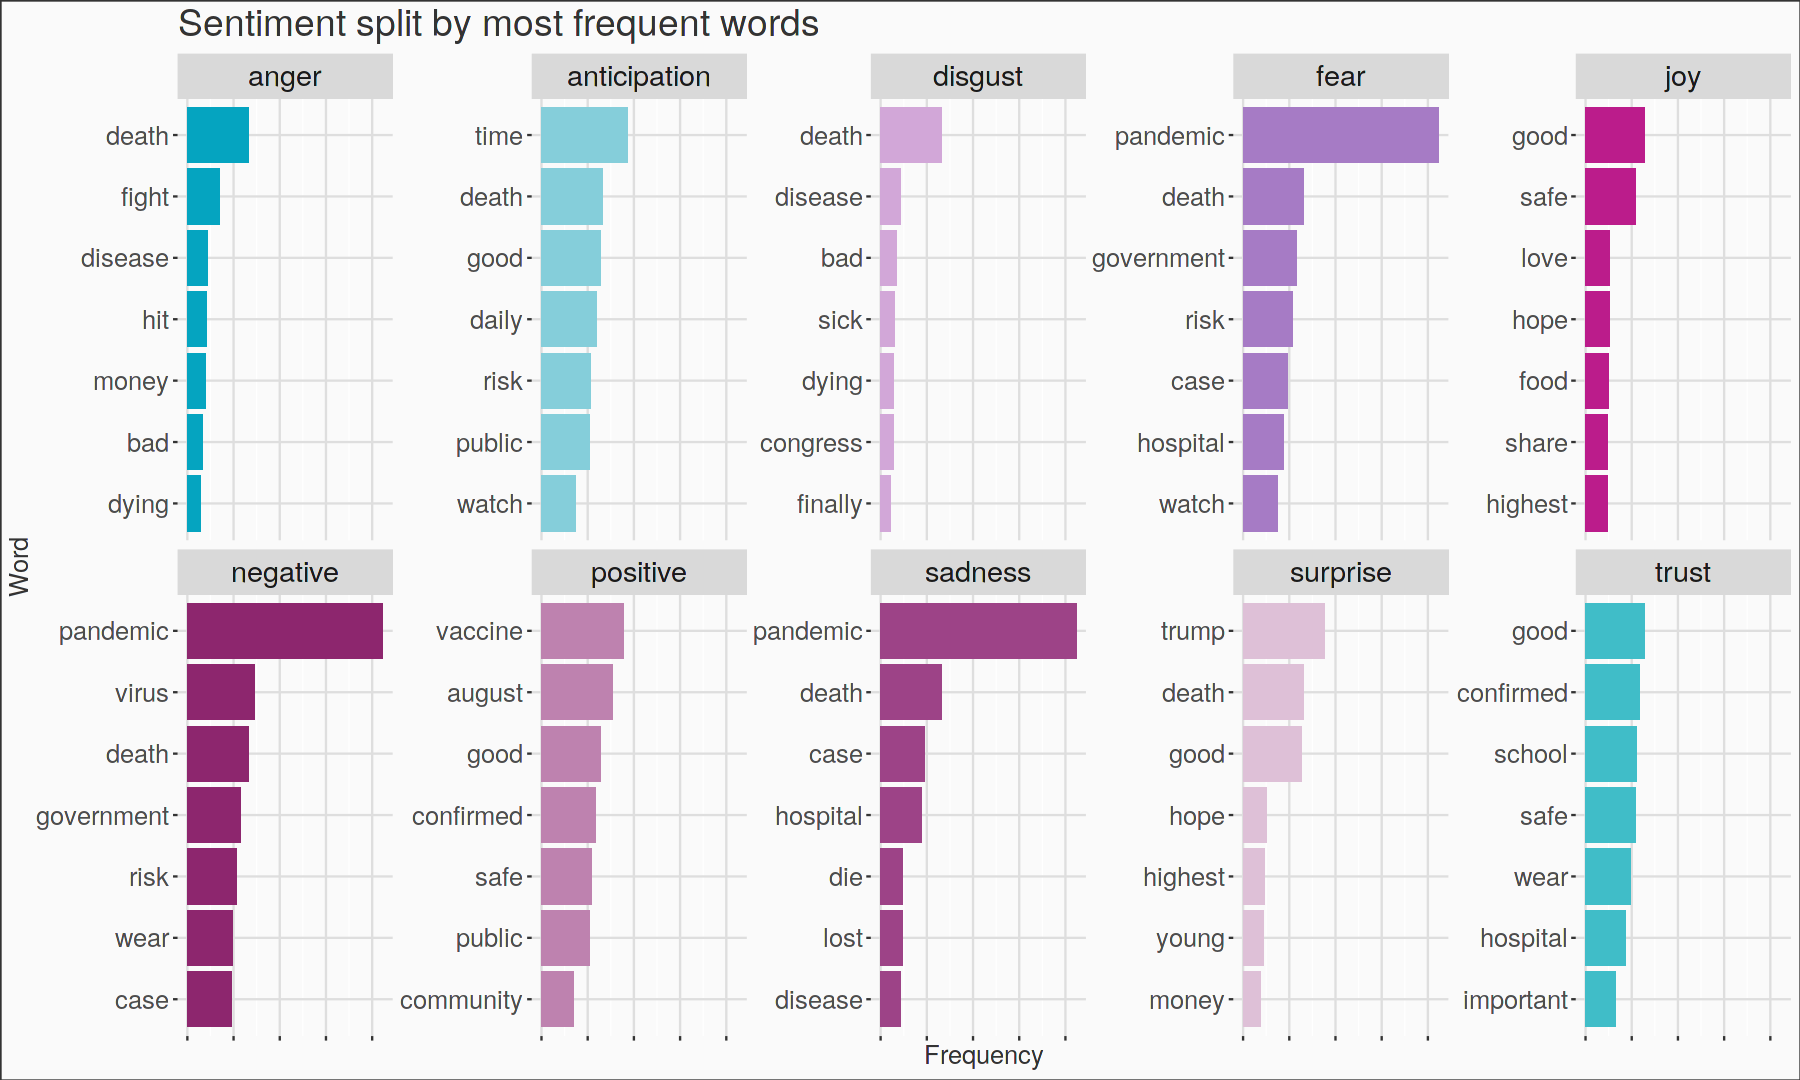

In [26]:
options(repr.plot.width=15, repr.plot.height=9)

unnest_tweets %>% 
  inner_join(nrc, "word") %>% 
  count(sentiment, word, sort=T) %>%
  group_by(sentiment) %>% 
  arrange(desc(n)) %>% 
  slice(1:7) %>% 
  
  # Plot:
  ggplot(aes(x=reorder(word, n), y=n)) +
  geom_col(aes(fill=sentiment), show.legend = F) +
  facet_wrap(~sentiment, scales = "free_y", nrow = 2, ncol = 5) +
  coord_flip() +
  my_theme + theme(axis.text.x = element_blank()) +
  labs(x="Word", y="Frequency", title="Sentiment split by most frequent words") +
  scale_fill_manual(values = c(my_colors, "#BE82AF", "#9D4387", "#DEC0D7",
                                 "#40BDC8", "#80D3DB", "#BFE9ED"))

## 6.4 Sentiment Distribution

> **📌Note:** There is quite an even distribution, with most of the words in the positive side, however many words in the negative side as well.

* Extremely positive words: *outstanding, thrilled, superb, breathtaking, amazing*
* Extremely negative words: some very bad words and swearing that I won't emphasize here (never knew these lexicons catch such vocabulary)

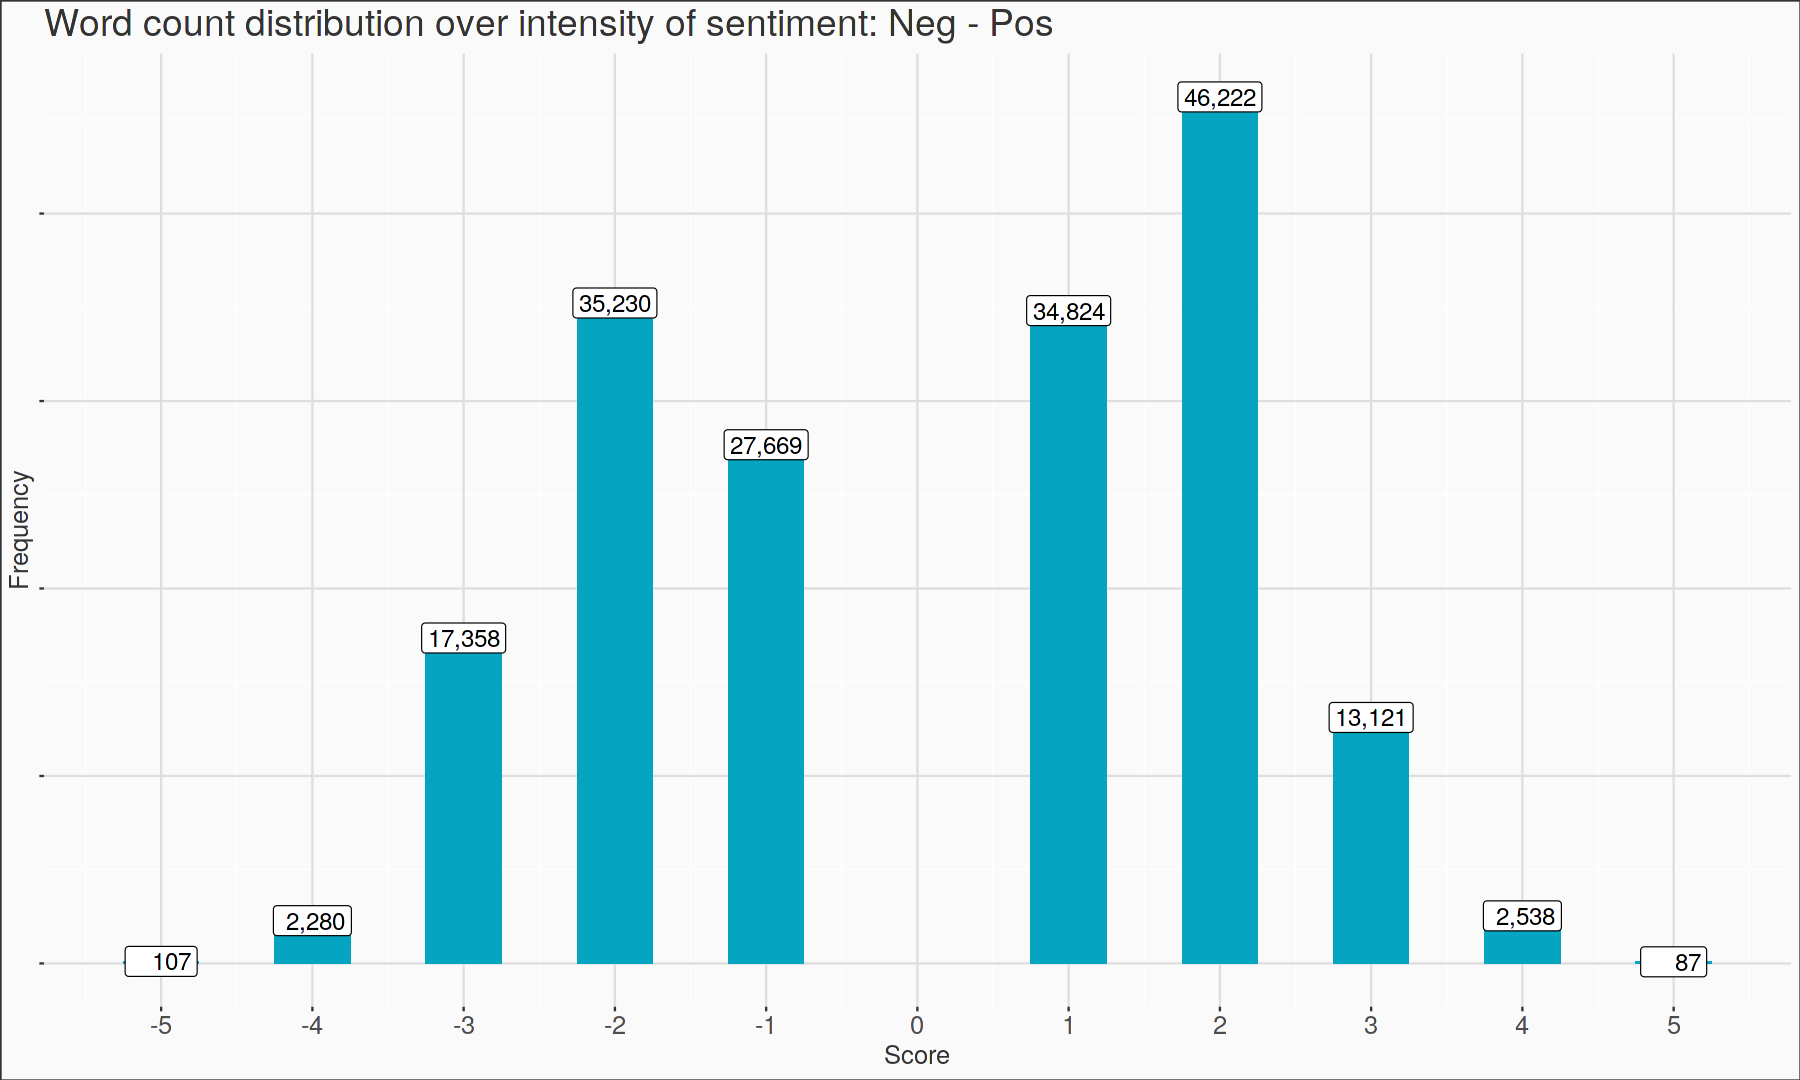

In [27]:
options(repr.plot.width=15, repr.plot.height=9)

unnest_tweets %>% 
  # Count how many word per value
  inner_join(afinn, "word") %>% 
  group_by(value) %>% 
  count(value, sort=T)  %>% 
  
  # Plot
  ggplot(aes(x=value, y=n)) +
  geom_bar(stat="identity", show.legend = F, width = 0.5, fill = my_colors[1]) +
  geom_label(aes(label=format(n, big.mark = ",")), size=5) +
  scale_x_continuous(breaks=seq(-5, 5, 1)) +
  labs(x="Score", y="Frequency", title="Word count distribution over intensity of sentiment: Neg - Pos") +
  my_theme + theme(axis.text.y = element_blank())

## 6.5 Chord Diagram

> **📌Note:** US, UK and the "worldwide" people have more negativity than positivity in the analyzed tweets. However, *India* looks to be much more positive 🙌

In [28]:
# Filter only main 3 countries with most tweets
data <- unnest_tweets %>%
            filter(country %in% c("US", "UK", "India", "NoCountry"))

# Create totals dataframe for the 3 countries
total_bing <- data %>% 
    inner_join(bing, by="word") %>%
    count(country) %>% 
    group_by(country) %>% 
    summarise(total_tweets = sum(n), .groups = "drop_last")

# The table
# total_bing

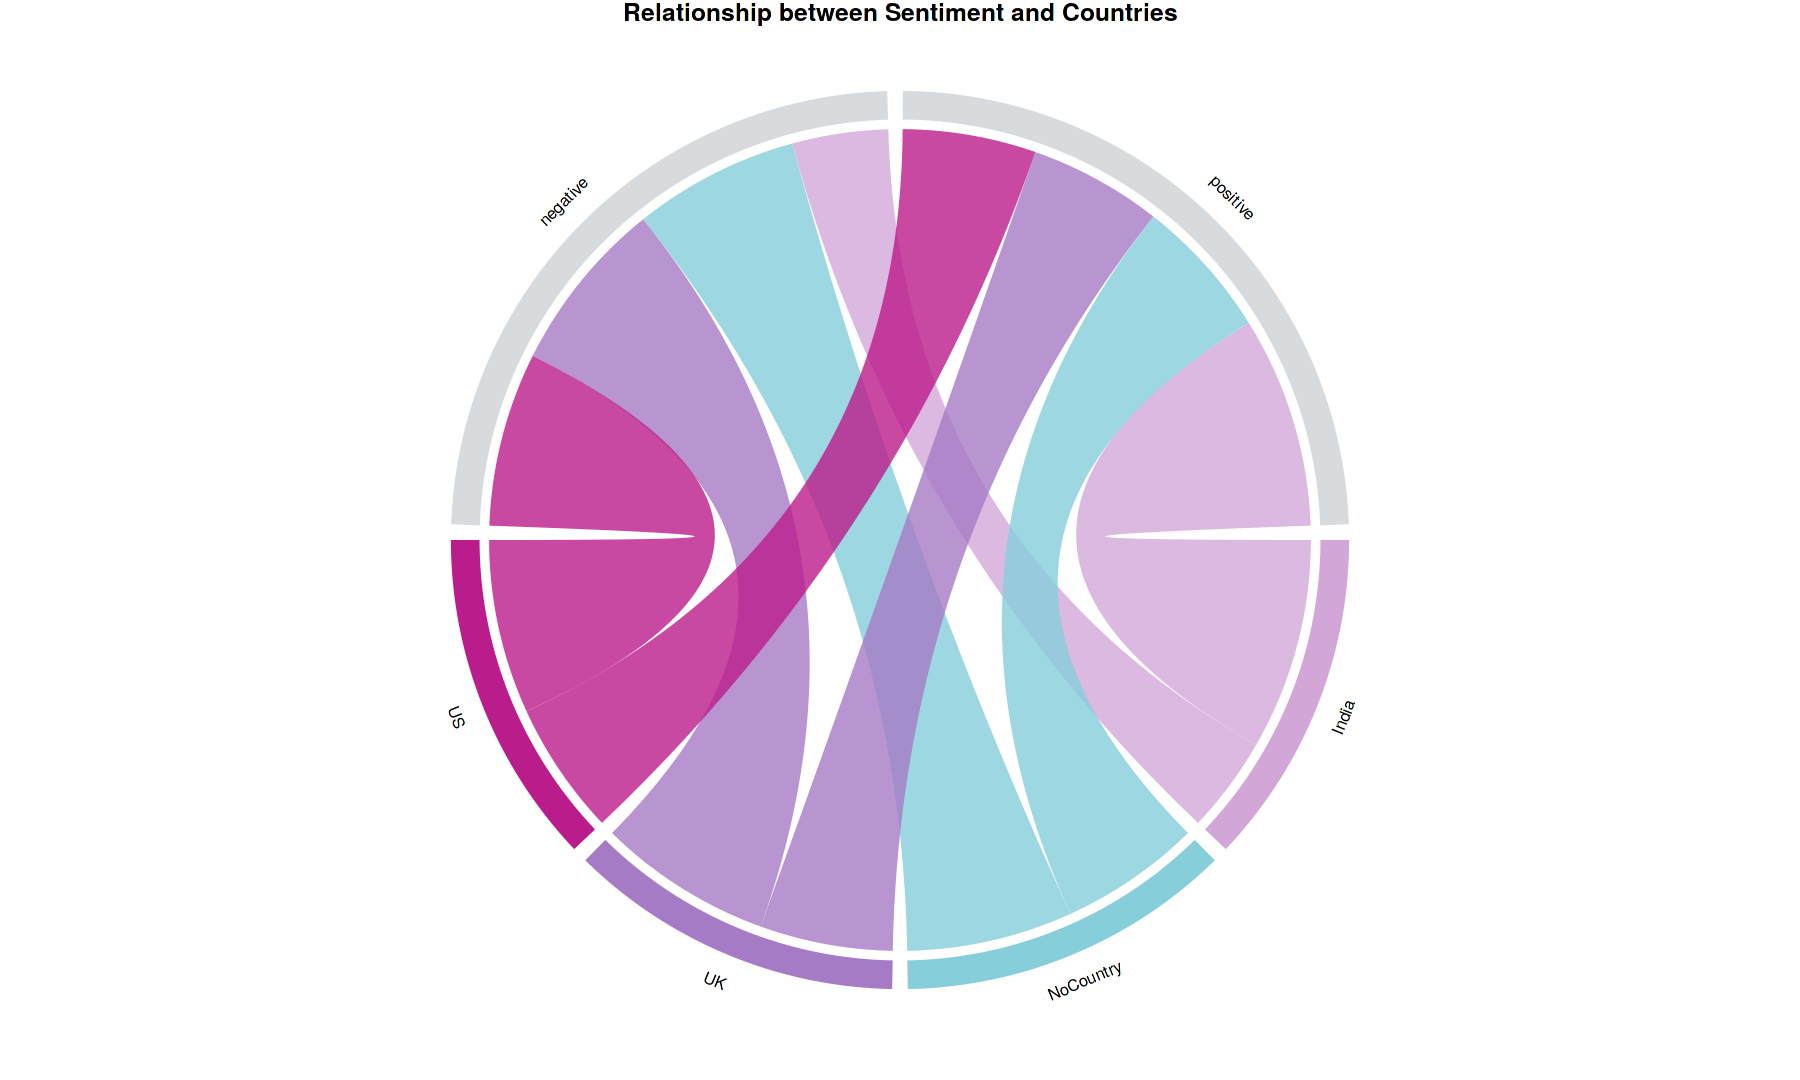

In [29]:
options(repr.plot.width=15, repr.plot.height=9)

to_plot <- data %>% 
    # get 'bing' and filter the data
    inner_join(bing, by="word") %>%

    # sum number of words per sentiment and country
    count(sentiment, country) %>% 
    group_by(country, sentiment) %>% 
    summarise(sentiment_sum = sum(n), .groups = "drop_last") %>% 
    inner_join(total_bing, by="country") %>% 
    mutate(sentiment_perc = sentiment_sum/total_tweets) %>% 
    select(country, sentiment, sentiment_perc)

# The Chord Diagram  
circos.clear()
circos.par(gap.after = c(rep(2, length(unique(to_plot[[1]])) - 1), 15,
                         rep(2, length(unique(to_plot[[2]])) - 1), 15), gap.degree=2)

myColors = c("India" = my_colors[3], "UK" = my_colors[4], "US" = my_colors[5], "NoCountry" = my_colors[2], 
             "positive" = "#D7DBDD", "negative" = "#D7DBDD")

chordDiagram(to_plot, grid.col = myColors, transparency = 0.2, annotationTrack = c("name", "grid"),
             annotationTrackHeight = c(0.03, 0.06))
title("Relationship between Sentiment and Countries")

## 6.6 Radar Chart

> **📌Note:** UK shows the most *trust* in their tweets, while US shows the most *disgust*. US and India also have a high score for *fear*.

In [30]:
# Filter only main 3 countries with most tweets
data <- unnest_tweets %>%
            filter(country %in% c("US", "UK", "India", "NoCountry"))

In [31]:
# Table with countries, sentiment and word count
char_sentiment <- data %>% 
    inner_join(nrc, "word") %>% 
    filter(!sentiment %in% c("positive", "negative")) %>% 
    group_by(country, sentiment) %>% 
    count(country, sentiment) %>% 
    select(country, sentiment, char_sentiment_count=n)

# Total Count of sentiments per countries
total_char <- data %>% 
    inner_join(nrc, "word") %>% 
    filter(!sentiment %in% c("positive", "negative")) %>% 
    count(country) %>% 
    select(country, total=n)

In [32]:
# Radar Chart:
plt <- char_sentiment %>% 
  inner_join(total_char, by="country") %>% 
  mutate(percent = char_sentiment_count / total * 100 ) %>% 
  select(-char_sentiment_count, -total) %>% 
  spread(country, percent)  %>% 
  chartJSRadar(showToolTipLabel = T, main="Countries Tweets and Emotion", maxScale=25, responsive=T,
               addDots = T, 
               colMatrix = grDevices::col2rgb(my_colors[c(3, 5, 4, 2)]),
               lineAlpha = 0.7, polyAlpha = 0.2)

# saveWidget(plt, "plt.html")

<img src="https://i.imgur.com/4Y1ZtJS.png" width=500>

## 6.7 Words with the biggest contribution in sentiment

> **📌Note**: Some of the most *positive* words are love, support and great, whereas some of the *negative* words are death, risk and crisis.

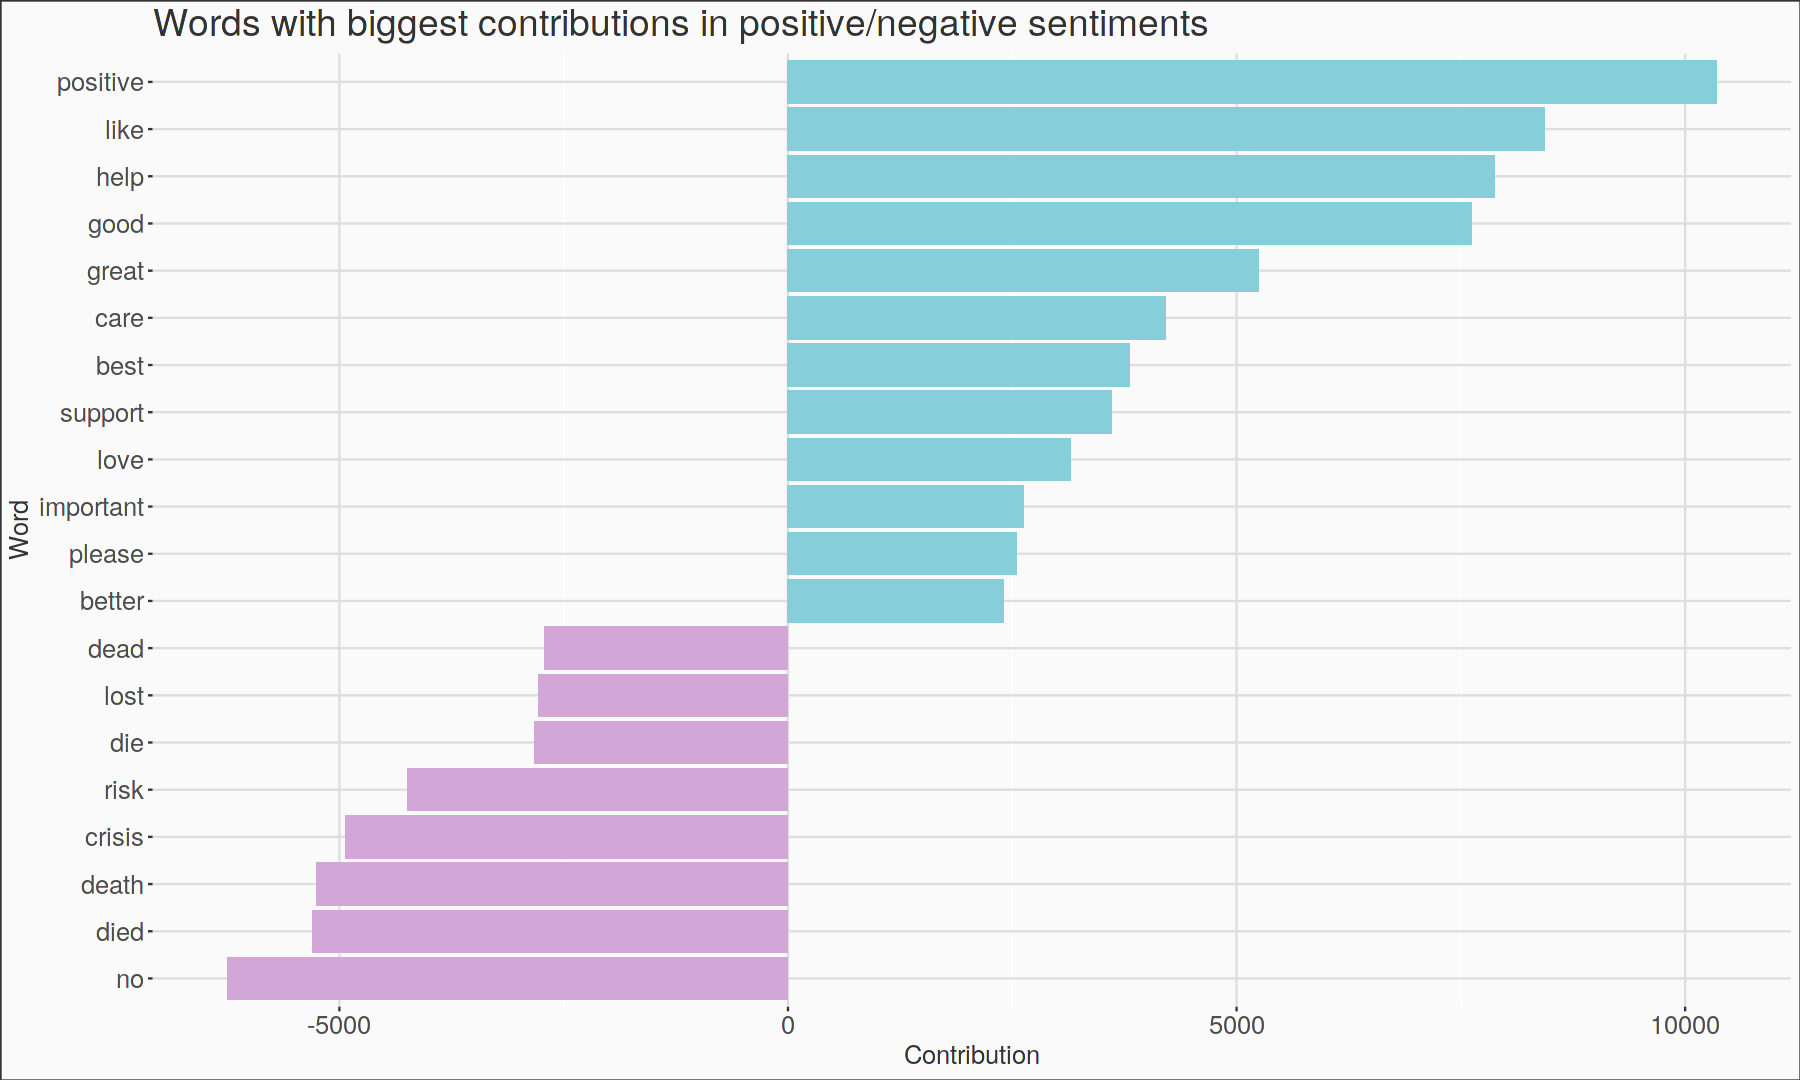

In [33]:
options(repr.plot.width=15, repr.plot.height=9)

unnest_tweets %>% 
  # by word and value count number of occurences
  inner_join(afinn, "word") %>% 
  count(word, value, sort=T) %>% 
  mutate(contribution = n * value,
         sentiment = ifelse(contribution<=0, "Negative", "Positive")) %>% #another variable
  arrange(desc(abs(contribution))) %>% 
  head(20)  %>% 
  
  # plot
  ggplot(aes(x=reorder(word, contribution), y=contribution, fill=sentiment)) +
  geom_col(aes(fill=sentiment), show.legend = F) +
  labs(x="Word", y="Contribution", title="Words with biggest contributions in positive/negative sentiments") +
  coord_flip() +
  scale_fill_manual(values=my_colors[c(3, 2)]) + 
  my_theme

# 7. Word Clouds

> I will erase the word `covid` from the frequency as it is too big (110,362 appearences to be exact) and minimizes the other words.

In [34]:
# wc_data <- frequentTerms(tweets$text) %>% filter(word != "covid")

# a <- wordcloud2(wc_data, size=1.6, minSize = 0.9, 
#            color='random-light', backgroundColor="black", shape="diamond", 
#            fontFamily="HersheySymbol")

# webshot::install_phantomjs()
# saveWidget(a,"1.html",selfcontained = F)
# webshot::webshot("1.html","1.png",vwidth = 1992, vheight = 1744, delay =10)

<img src="https://i.imgur.com/alupn9d.png" width = 700>

# 8. Bigrams 🐥🐥 and Trigrams 🐥🐥🐥

## #1. Frequent Bigrams

> `amp` shows a lot, and I think it is the abbreviation for "Ain't My Problem"/ or is it "amplifier"? However, if you're a native english speaker and you think otherwise, please comment and I can change the explanation. :)

In [35]:
bigram <- frequentBigrams(tweets %>% 
                            filter(country %in% c("US", "UK", "India", "NoCountry")) %>% 
                            select(text) %>% 
                            drop_na(text)) %>%
                head(25)

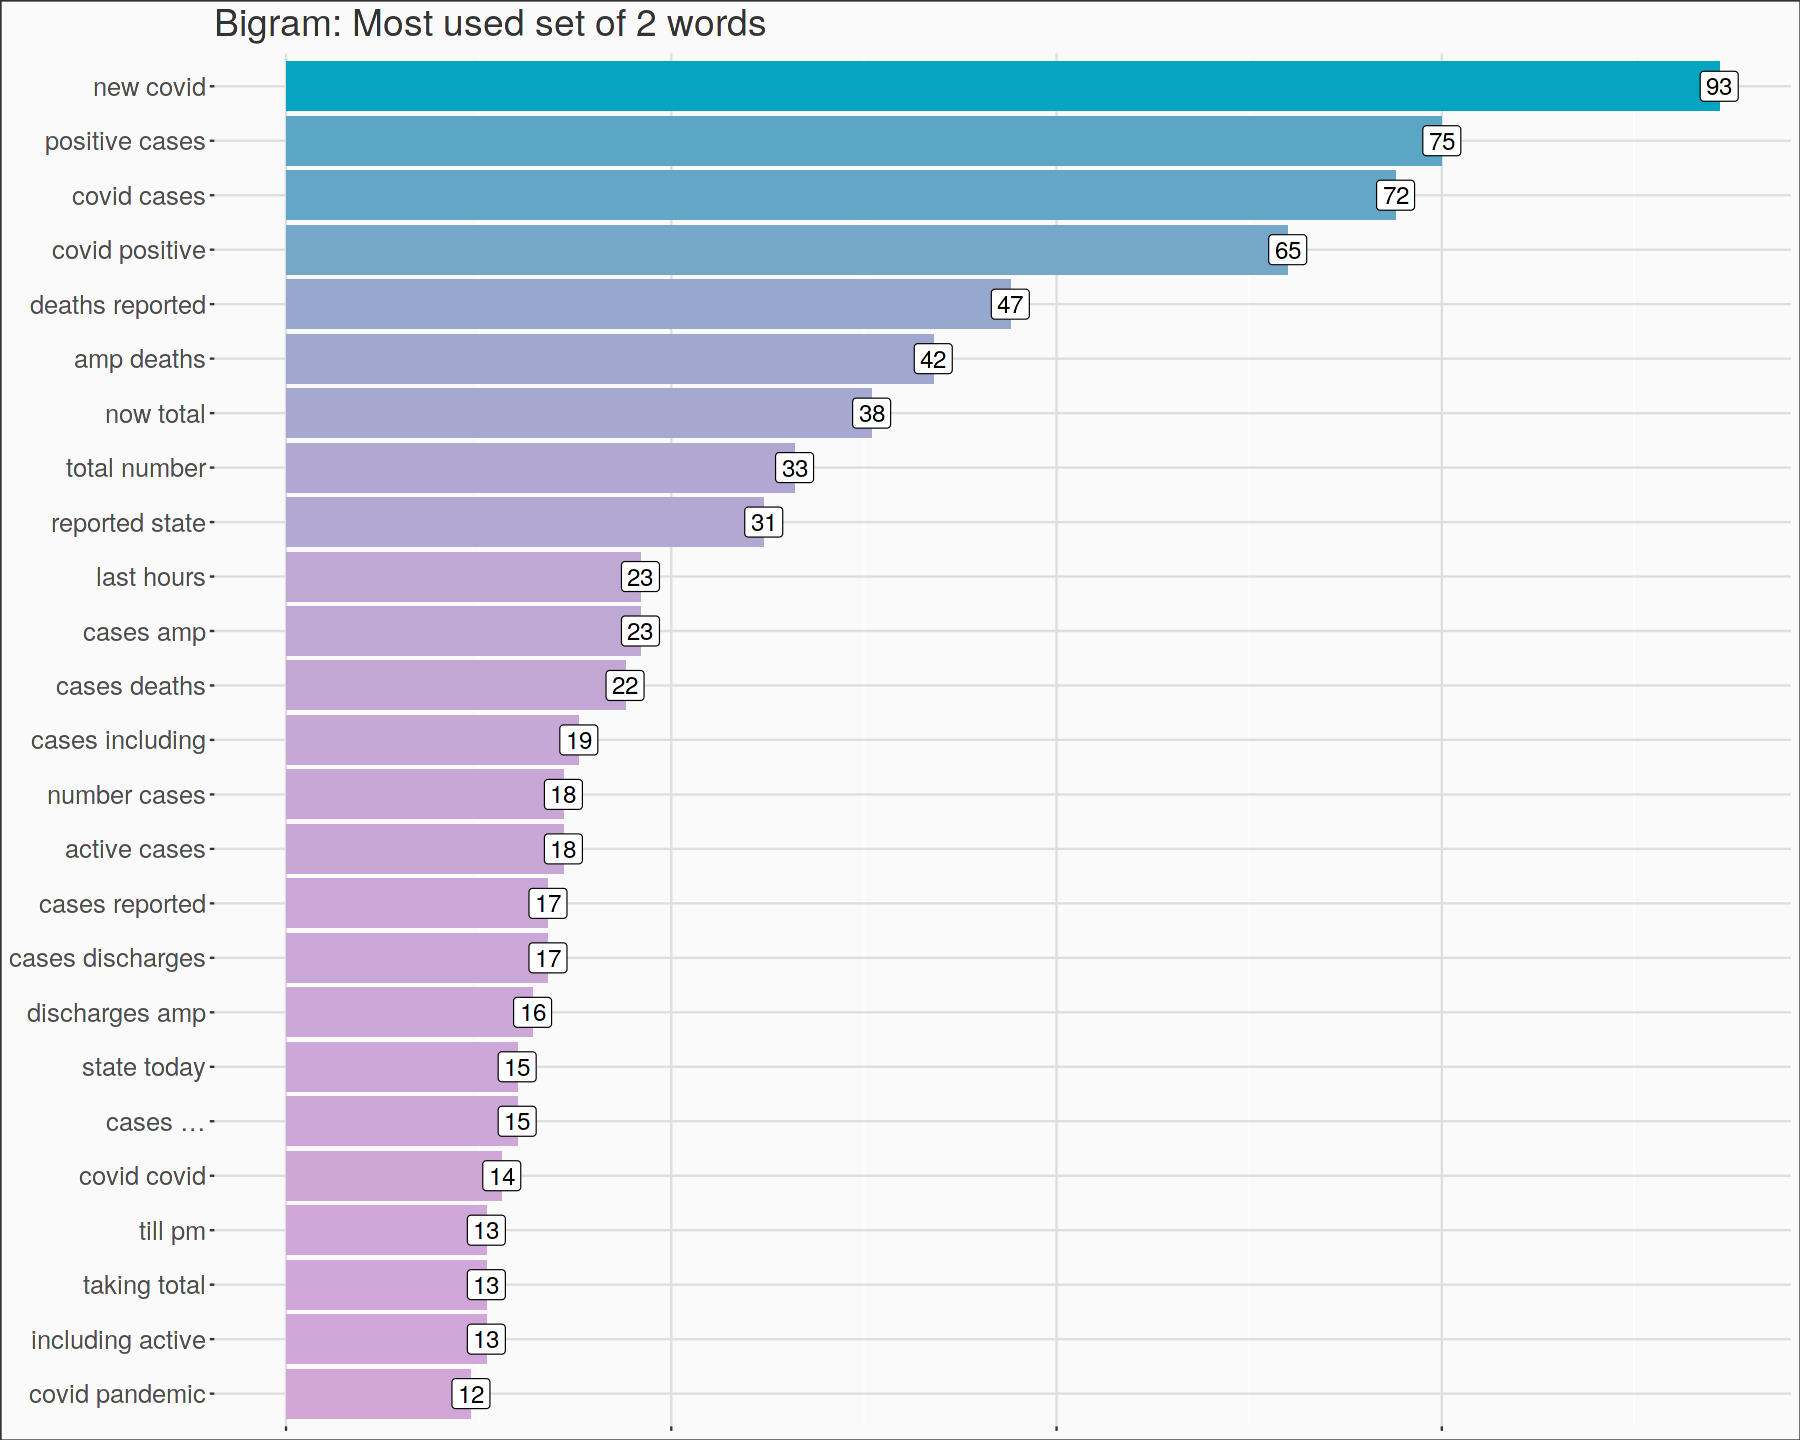

In [36]:
options(repr.plot.width=15, repr.plot.height=12)

# Bigram plot
bigram %>%
  ggplot(aes(x=reorder(word, freq), y=freq)) +
  geom_bar(stat="identity", aes(fill=freq), show.legend = F) +
  geom_label(aes(label=freq), size=5) +
  labs(title="Bigram: Most used set of 2 words") +
  scale_fill_gradient(low = my_colors[3], high = my_colors[1], guide="none") +
  my_theme + theme(axis.text.x = element_blank(), axis.title = element_blank()) +
  coord_flip()

## #2. Frequent Trigrams


In [37]:
trigram <- frequentTrigrams(tweets %>% 
                            filter(country %in% c("US", "UK", "India", "NoCountry")) %>% 
                            select(text) %>% 
                            drop_na(text)) %>%
                head(25)

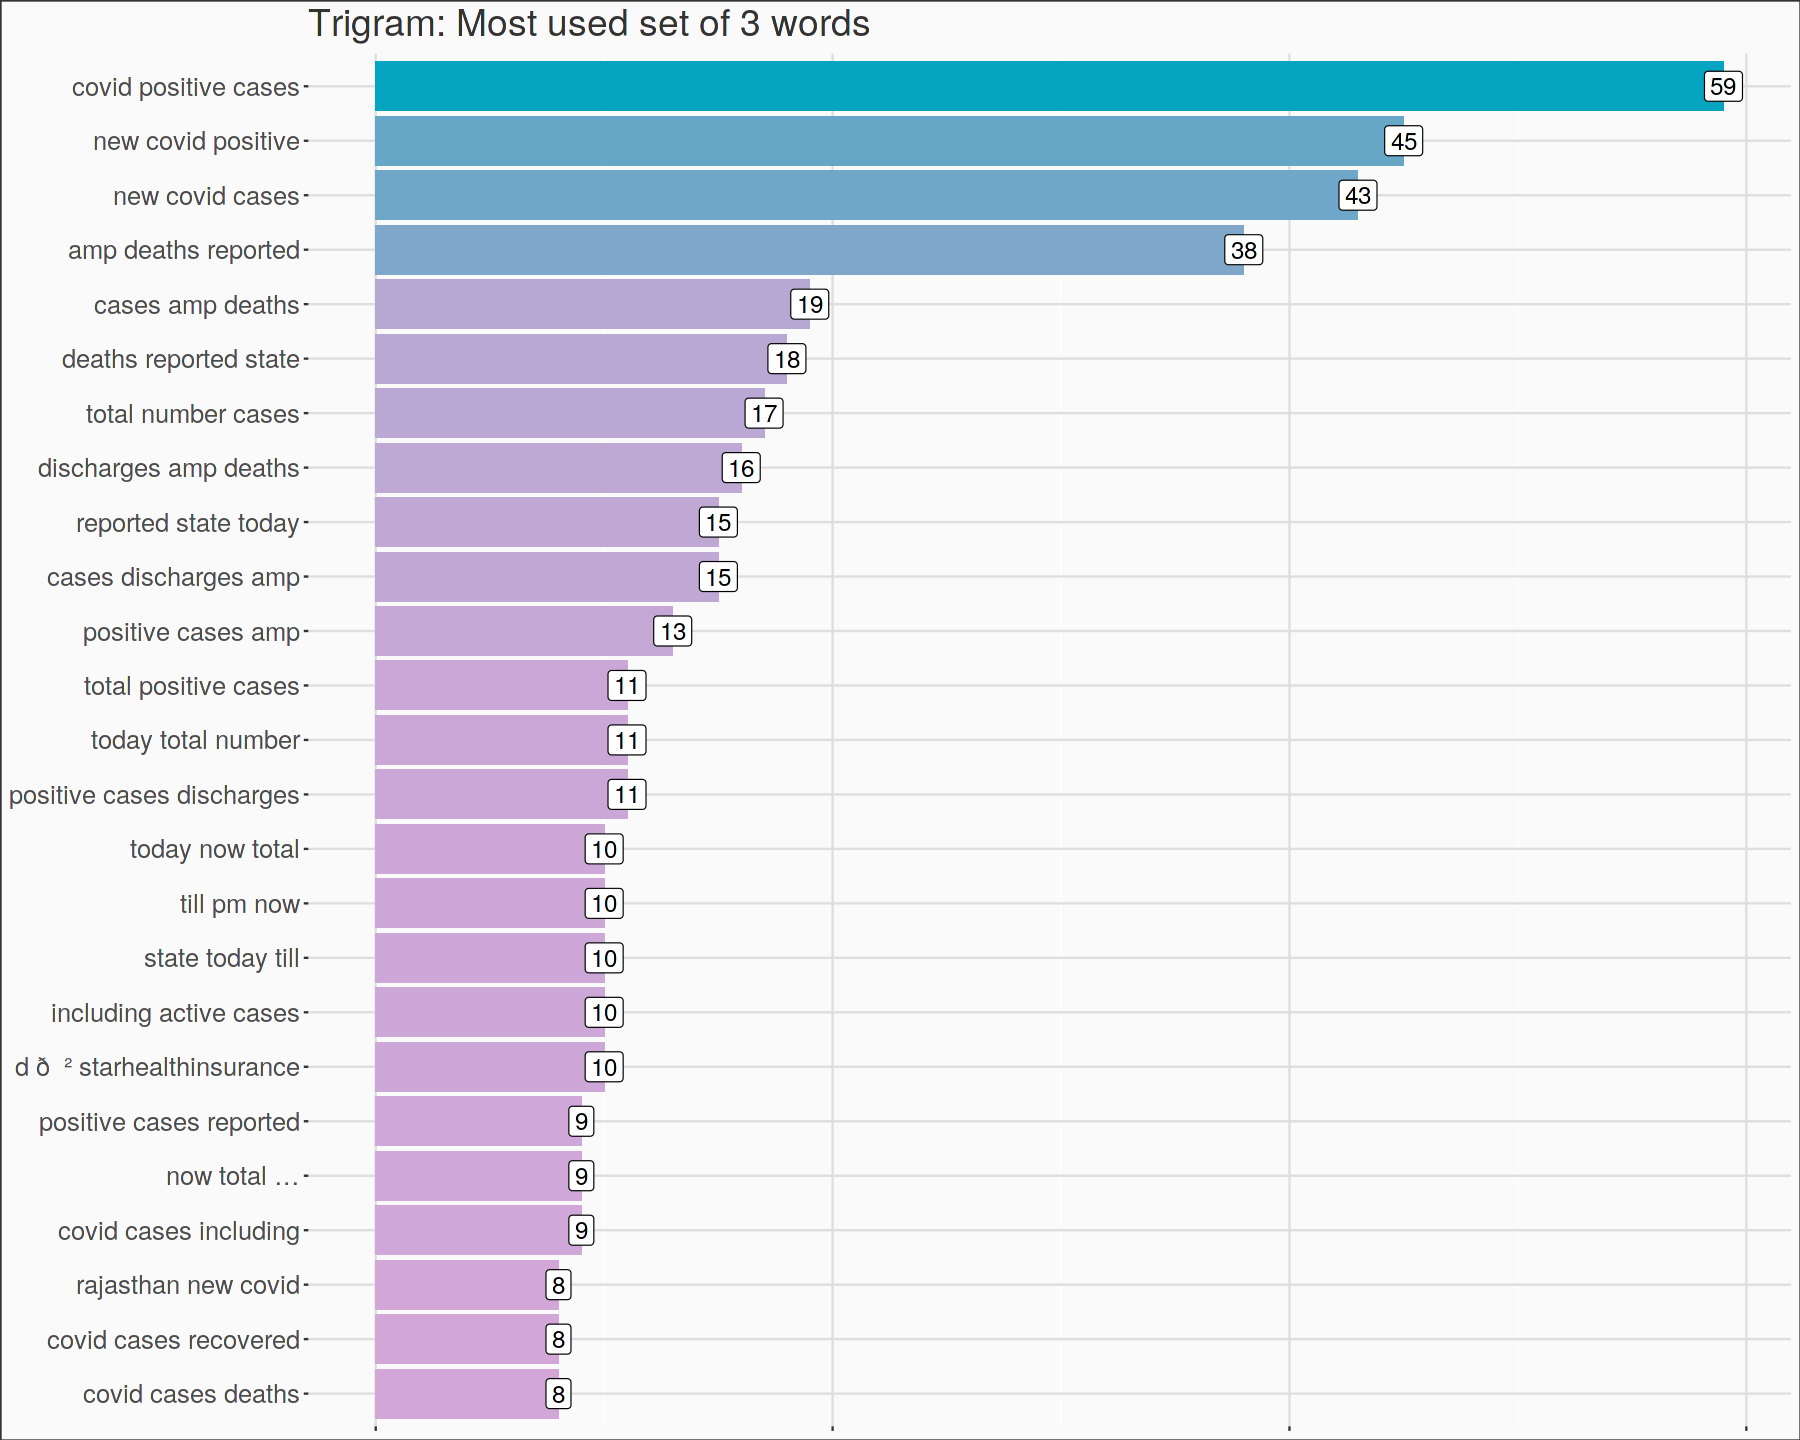

In [38]:
options(repr.plot.width=15, repr.plot.height=12)

# Trigram plot
trigram %>%
  ggplot(aes(x=reorder(word, freq), y=freq)) +
  geom_bar(stat="identity", aes(fill=freq), show.legend = F) +
  geom_label(aes(label=freq), size=5) +
  labs(title="Trigram: Most used set of 3 words") +
  scale_fill_gradient(low = my_colors[3], high = my_colors[1], guide="none") +
  my_theme + theme(axis.text.x = element_blank(), axis.title = element_blank()) +
  coord_flip()

# 9. Social Network Analysis

<div class="alert alert-block alert-info">
A better way to visualize the connection between the most frequent combination of words is through networks (or graphs). Here we'll explore this option for the tweets made in english for the 4 countries observed previously.
</div>

In [39]:
install.packages("ndtv")

# Libraries
library(igraph)
library(ggraph)
library(network)
library(sna)
library(visNetwork)
library(threejs)
library(networkD3)
library(ndtv)
library(qgraph)
library(splitstackshape)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘networkDynamic’, ‘base64’


network: Classes for Relational Data
Version 1.16.0 created on 2019-11-30.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.



Attaching package: ‘network’


The following objects are masked from ‘package:igraph’:

    %c%, %s%, add.edges, add.vertices, delete.edges, delete.vertices,
    get.edge.attribute, get.edges, get.vertex.attribute, is.bipartite,
    is.directed, list.edge.attributes, list.vertex.attributes,
    set.edge.attribute, set.vertex.attribute


Loading

I. First we create the bigrams as did before (however, here we won't use only the first 25 rows, but the entire table). The only thing we'll filter is the combination of words that appear less than 5 times (freq < 5).

In [40]:
# Create dataframe
bigram <- frequentBigrams(tweets %>% 
                            filter(country %in% c("US", "UK", "India", "NoCountry")) %>% 
                            select(text) %>% 
                            drop_na(text)) %>%
                cSplit("word", " ") %>%
                mutate(word_1 = as.character(word_1),
                       word_2 = as.character(word_2)) %>%
                mutate(word_1 = ifelse(word_1=="case", "cases", word_1),
                       word_2 = ifelse(word_2=="case", "cases", word_2)) %>%
                filter(freq >= 5)

# Rename and reorder columns (so we can make the graphs more easily)
names(bigram) <- c("n", "item1", "item2")
bigram <- bigram[ , c(2, 3, 1)]

# Inspect data
bigram %>% head()

item1,item2,n
<chr>,<chr>,<dbl>
new,covid,93
positive,cases,75
covid,cases,72
covid,positive,65
deaths,reported,47
amp,deaths,42


II. Create the `sources` and `destinations` dataframes, where:
* the *source* is the first word of the bigram
* the *destination* is the second word of the bigram

In [41]:
# Distinct Item1
sources <- bigram %>% 
                distinct(item1) %>% 
                rename(label = item1)

# Distinct item2
destinations <- bigram %>% 
                    distinct(item2) %>% 
                    rename(label = item2)

III. Now we can create the nodes and the edges of the graph, where:
* `nodes` are the unique words - each word has an identification ID
* `edges` are the *bigrams*, meaning that they show how frequently we find a combination of 2 words (represented by their unique ID)

*To understand better chech the 2 heads of the tables below*

In [42]:
# ----- NODES -----
# Unique Items + create unique ID
nodes <- full_join(sources, destinations, by="label") %>% rowid_to_column("id")

# ----- EDGES -----
# Adds unique ID of Item 1 to data
edges <- bigram %>% 
            left_join(nodes, by = c("item1" = "label")) %>% 
            rename(from = id)

# Adds unique ID of Item 2 to data
edges <- edges %>% 
            left_join(nodes, by = c("item2" = "label")) %>% 
            rename(to = id) %>% 
            rename(weight = n)

# Select only From | To | Weight (frequency)
edges <- edges %>% select(from, to, weight)

In [43]:
nodes %>% head(3)
edges %>% head(3)

id,label
<int>,<chr>
1,new
2,positive
3,covid


from,to,weight
<int>,<int>,<dbl>
1,3,93
2,9,75
3,9,72


In [44]:
# Export the nodes & edges data - I use this later for the more complex network
write.csv(nodes,"nodes.csv", row.names = FALSE)
write.csv(edges,"edges.csv", row.names = FALSE)

### Making the IGraph

Now let's create the actual network visualization. This is where insight meets beauty 💜

In [45]:
# Create network
net <- graph_from_data_frame(d = edges, vertices = nodes, directed = TRUE)
net <- simplify(net, remove.multiple = F, remove.loops = T)
# net

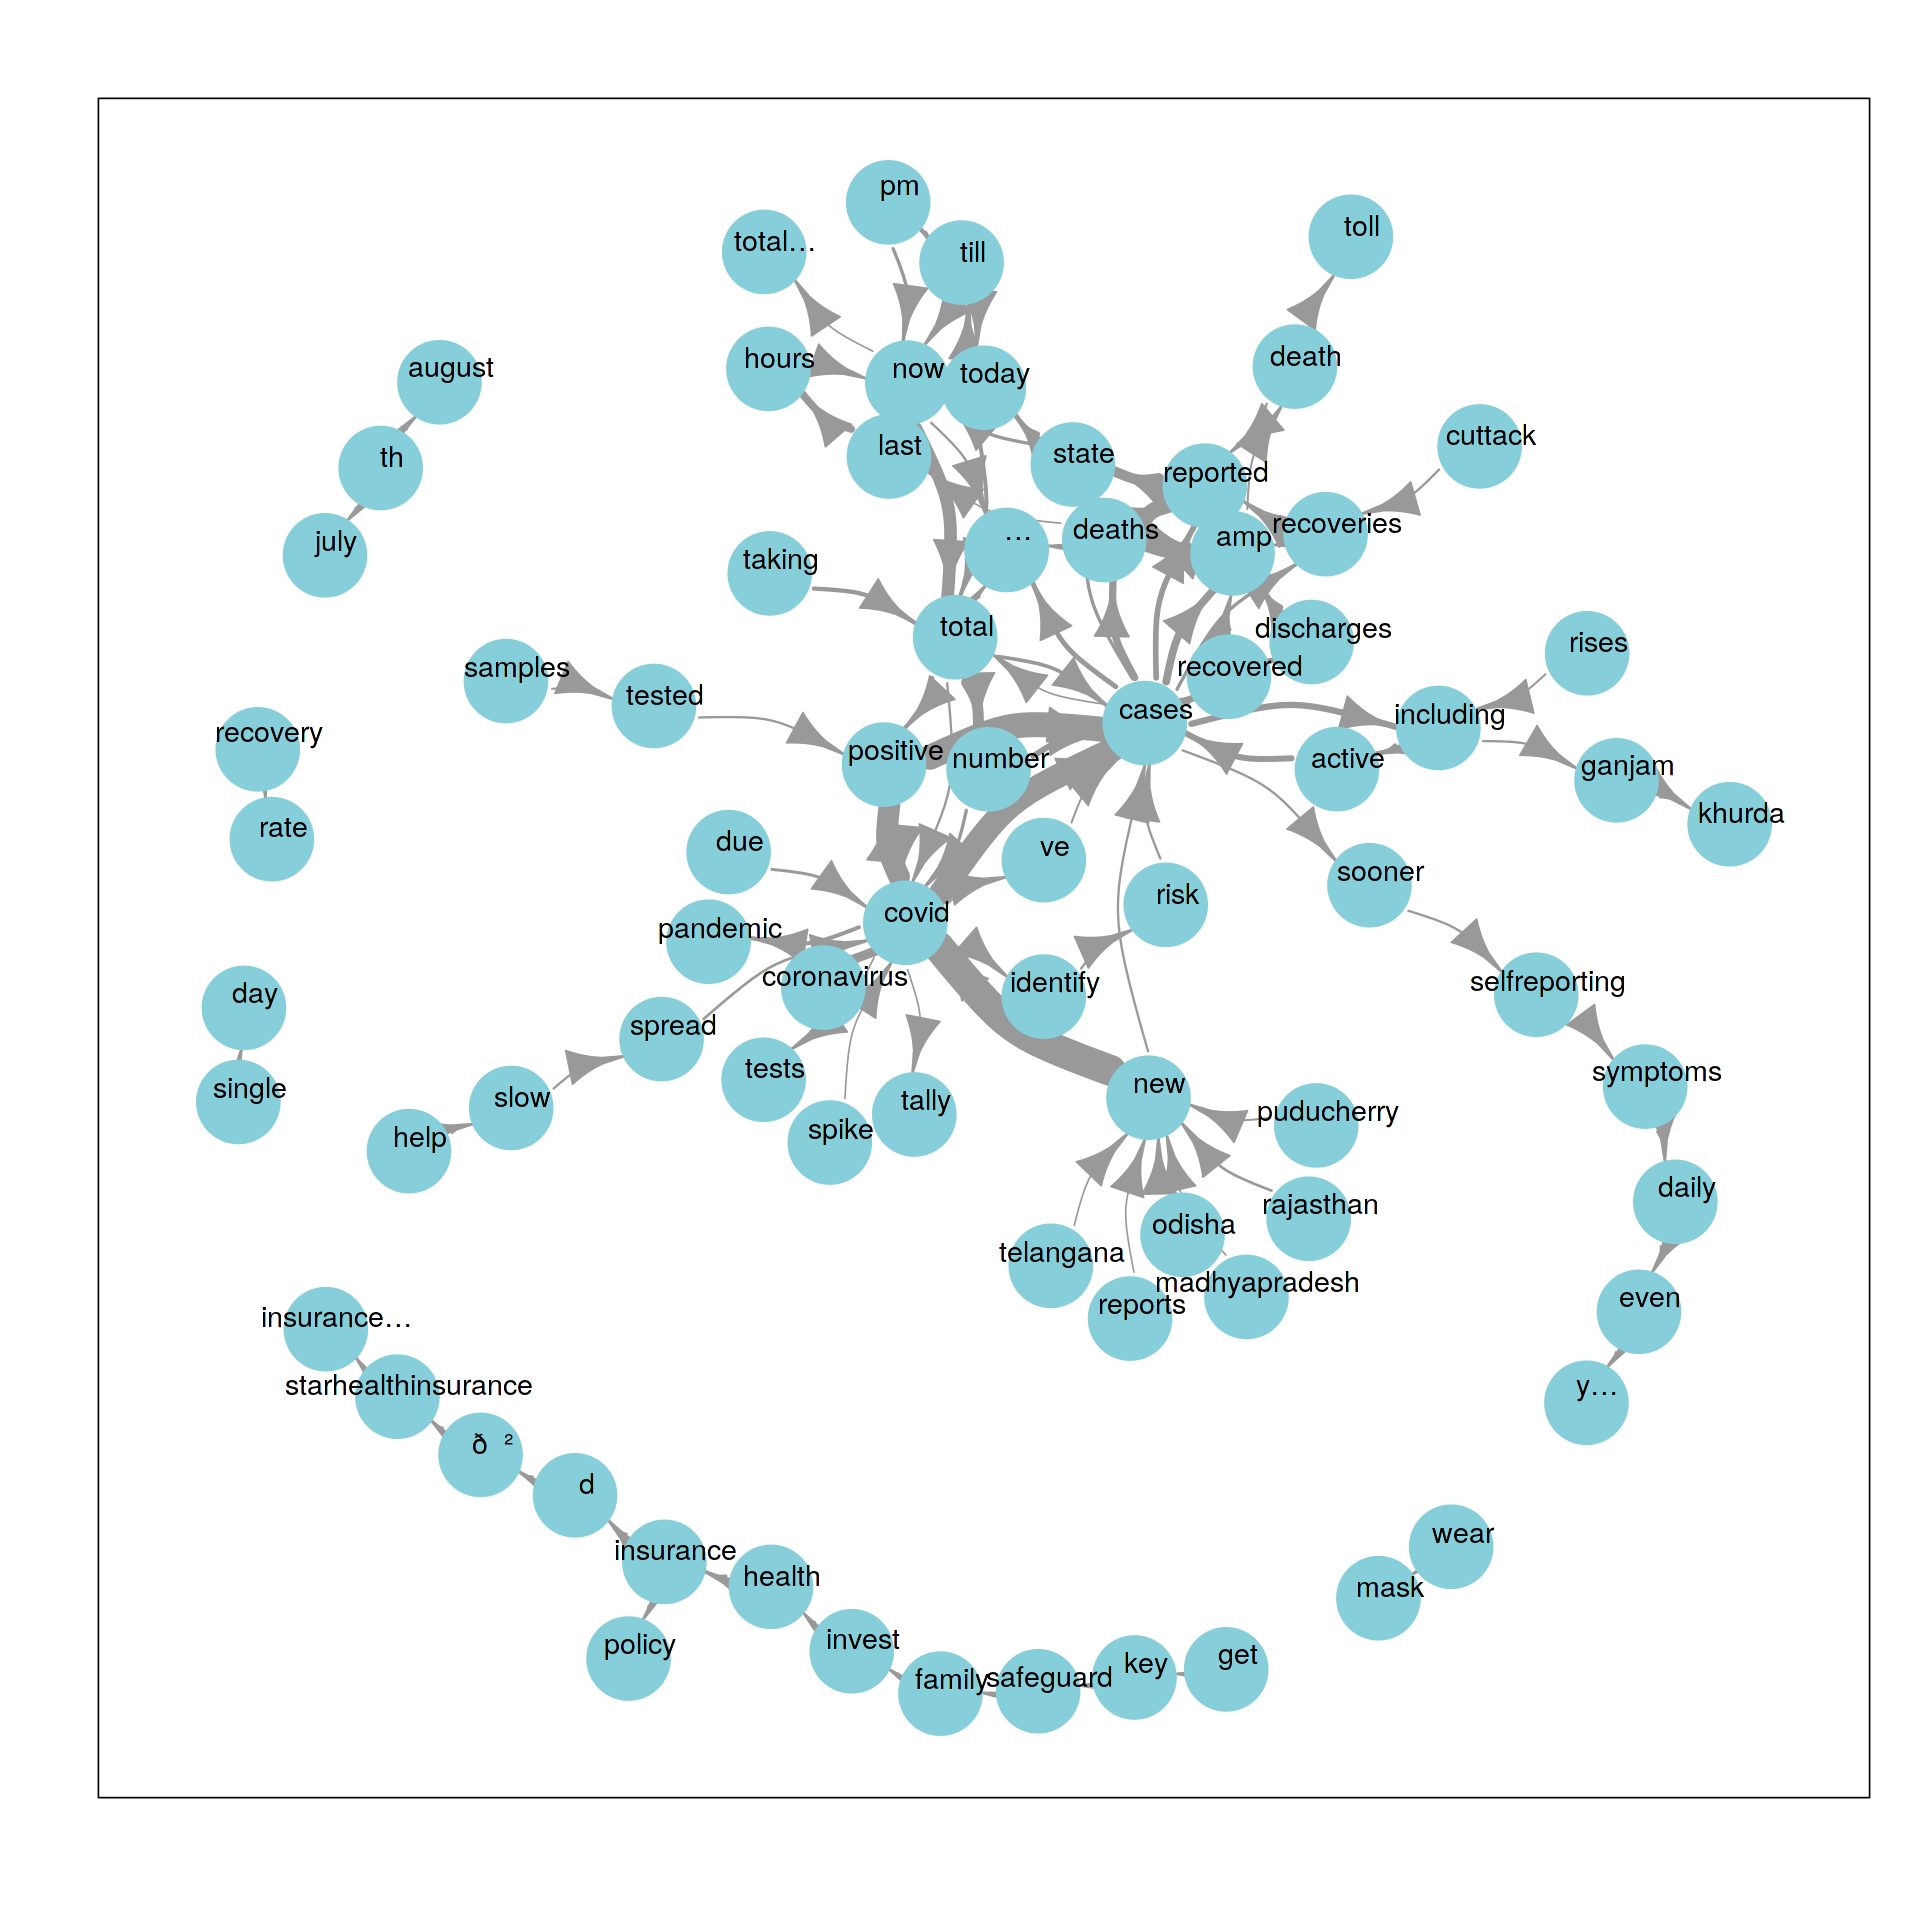

In [46]:
options(repr.plot.width=16, repr.plot.height=16)
set.seed(123)

#change arrow size and edge color:
E(net)$width <- E(net)$weight/5
E(net)$arrow.size <- 0.8

# Layout
e <- get.edgelist(net, names=F)
l <- qgraph.layout.fruchtermanreingold(e, vcount=vcount(net), niter = 90000)

# Cluster colors
colrs <- my_colors[2]

plot(net, edge.curved=.3, layout = l,
     vertex.size=11, vertex.color = colrs, vertex.frame.color=colrs,
     vertex.label.color="black", vertex.label.font = 1, vertex.label.cex = 1.4, vertex.shape="circle",
     vertex.label.dist = 0.3,
     edge.color = "grey60", frame=T,
     vertex.label=(V(net)$label),
     mark.col = "grey96", mark.border="grey88")

## Graphs 2.0 - community detection

> To perform community detection, `glpk` library is needed ([discussion here](https://www.kaggle.com/questions-and-answers/182372)). If you have any information about how to install it on Kaggle environment, I'll appreciate it if you'd share it :)

*Until then, I'll comment the code adjusted to make the community detection and add the picture of the network*

In [47]:
# # Install the libraries
# install.packages("glpk")
# library(glpk)

In [48]:
# # Create network
# net <- graph_from_data_frame(d = edges, vertices = nodes, directed = TRUE)
# net <- simplify(net, remove.multiple = F, remove.loops = T)

# # Community Detection
# clp <- cluster_optimal(net)
# V(net)$community <- clp$membership

In [49]:
# # ==== Create cluster list for the shaded area ====
# clusters <- data.frame(V(net)$community, V(net)$name) %>% 
#                 group_by(V.net..community) %>% 
#                 mutate(group = paste0(V.net..name, collapse = " ")) %>% 
#                 summarise(group2 = first(group))

# cluster_list <- clusters[["group2"]]

# # List instances
# final_list = list()
# i <- 1

# for (group in cluster_list){
#     numbers <- str_split(group, pattern = " ")
#     final_list[i] <- numbers
#     i <- i+1
# }

In [50]:
# set.seed(123)

# png("Igraph.png", height=16, width=16, units="in", res=250)

# #change arrow size and edge color:
# E(net)$width <- E(net)$weight/5
# E(net)$arrow.size <- 0.8

# # Layout
# e <- get.edgelist(net, names=F)
# l <- qgraph.layout.fruchtermanreingold(e, vcount=vcount(net), niter = 90000)

# # Cluster colors
# colrs <- adjustcolor( c(my_colors, "yellowgreen", "yellowgreen", "lightblue", "lightblue",
#                         "lightgreen", "maroon", "#86C1B2", '#86C1B2'), alpha=.9)

# plot(net, edge.curved=.3, layout = l,
#      vertex.color = colrs[V(net)$community], vertex.frame.color=colrs[V(net)$community], vertex.size=11,
#      vertex.label.color="black", vertex.label.font = 1, vertex.label.cex = 1.4, vertex.shape="circle", 
#      vertex.label.dist = 0.3, 
#      edge.color = "grey60", frame=T,
#      vertex.label=(V(net)$label),
#      mark.groups = final_list, mark.col = "grey96", mark.border="grey88")

# dev.off()

<img src="https://i.imgur.com/XM1s58X.png" width= 900>

> Well, this is something beautiful 💜. Let's break down some of the main topics:

**Small topics (2-3 words)**
   * wear (a) mask
   * recovery rate
   * samples tested
   * help slow (the) spread
   * single day
   * nth July/ August (the months we've been looking at so far)
    
    
**Bigger topics (more than 4-5 words)**
   * Blue Middle cluster: talking about new covid cases (in different cities Odisha, Telangana, etc.)
   * Light Purple cluster: talking about time (pm, now, today) and cases numbers
   * Deep Purple on the bottom cluster: talking about healthcare, insurance and family ("get key safeguard (for) family", "invest (in) health insurance policy")

# 10. TF-IDF

**TF-IDF (term frequency-inverse document frequency)**
* is a statistical measure that evaluates how relevant a word is to a document in a collection of documents
* is done by multiplying two metrics: *how many times a word appears in a document*, and the *inverse document frequency of the word across a set of documents*.
* It works by increasing proportionally to the number of times a word appears in a document, but is **offset** by the number of documents that contain the word (words that are common in every document, such as this, what, and if, rank low even though they may appear many times).
* However, if the word Bug appears many times in a document, while not appearing many times in others, it probably means that it’s very relevant.

In [51]:
# # Compute the tf_idf metric
# unnest_tweets %>% 
#         anti_join(stopwords_script, "word") %>%
#         filter(!is.na(word)) %>%
#         filter(country != NA) %>%
#         count(country, word, sort=T)

In [52]:
# tf_idf_tweets %>% 
#     filter(!is.na(word)) %>%
#     select(word, tf_idf) %>% 
#     as.data.frame() %>%
#     mutate(word = as.factor(word)) %>% 
#     arrange(desc(tf_idf))

# Work in Progress... ⏳